
# Demo Metro Line with Genetic Algorithms



In [1]:
import random
import copy

import haversine as hs
from haversine import haversine
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
from sklearn import decomposition  # Algoritmos de reduccion de dimensionalidad.
import smopy
import tqdm
import seaborn as sns
import kruskal

%matplotlib inline

<a id="ej2"></a>

## Diseño de redes de transporte

Imaginemos que un famoso magnate llamado Melon Mask ha culminado su nuevo invento: el hypermegaminiloop. Que revoluciona el transporte urbano, pero de momento es muy muy caro.

El alcalde de Nueva York se ha enterado de su existencia y quiere ser un *early adopter* del proyecto y complementar (que no sustituir) su red de transporte. Para ello se dispone de datos de la [demanda de Uber](https://data.world/data-society/uber-pickups-in-nyc) que con este nuevo método se pretende cubrir.

Se provee de un subconjunto del dato representativo pero de menor tamaño para evitar que su procesado conlleve tiempos de ejecución muy grandes.

In [2]:
df = pd.read_csv('uber_sample.csv')
df.head(3)

Date/Time      Lat      Lon    Base
0   9/16/2014 5:37:00  40.7651 -73.9615  B02764
1  9/21/2014 12:12:00  40.7249 -73.9947  B02764
2  9/22/2014 12:50:00  40.7720 -73.9590  B02598

Visualizamos los datos para ver donde hay mayor concentración de peticiones y facilitar el posterior análisis de los datos. ¿Puedes localizar *Central Park*?

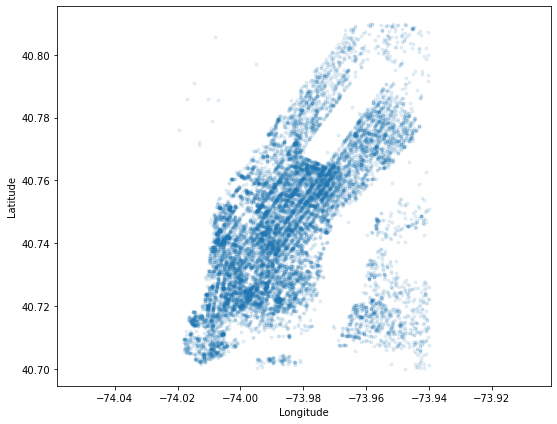

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(df['Lon'], df['Lat'], s=8, alpha=.1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('equal')
plt.tight_layout()

### 2 a. Localización de las paradas: clustering

La primera parte del diseño de la red de transporte es situar las futuras paradas. Para ello tendrás que identificar entre 100 y 200 lugares del mapa (aproximación aportada por el departamento de transporte de la ciudad) con alta concentración de demanda.

Puedes elegir cualquier algoritmo de clustering para este cometido, pero recuerda que tendrás que justificar la respuesta para la propuesta de proyecto.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
elige y aplica una técnica de clustering para encontrar entre 100 y 200 grupos de puntos.
</div>

En este punto escogeré la técnica de clustering DBSCAN para encontrar los grupos. Los motivos se explicarán más abajo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los grupos encontrados dotando de color a los puntos en base al cluster al que pertenecen. Puedes utilizar el colormap 'tab20' para tener una paleta de color discreta y amplia que permita visualizar mejor los resultados.
</div>

146


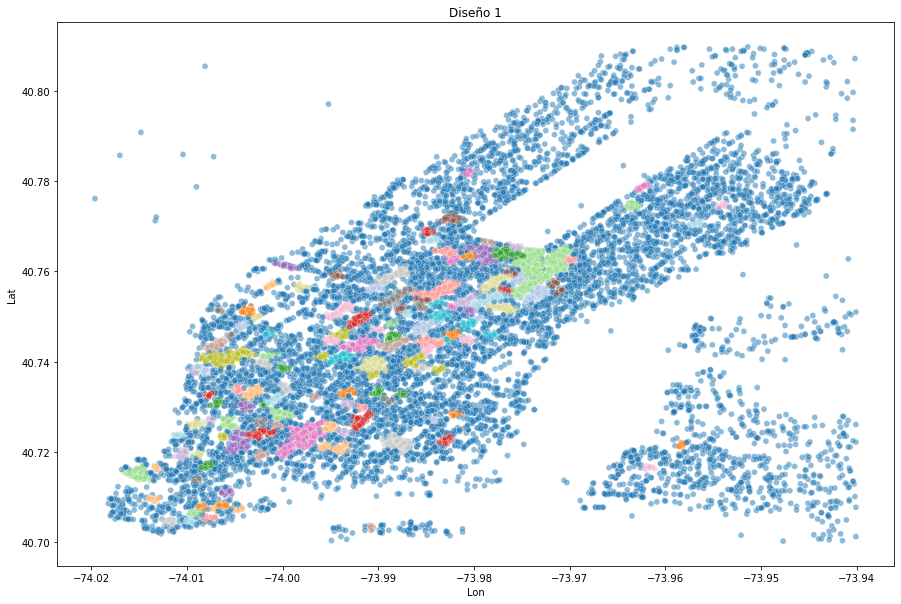

In [4]:
dat =df[['Lon', 'Lat']]
clustering = cluster.DBSCAN(eps=0.0006, min_samples=15).fit(dat)
print(len(set(clustering.labels_)))


plt.figure(figsize=(15,10))

plt.title('Diseño 1')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], palette='tab20', alpha=.5, hue=clustering.labels_)

plt.legend([],[], frameon=False)
plt.show()

195


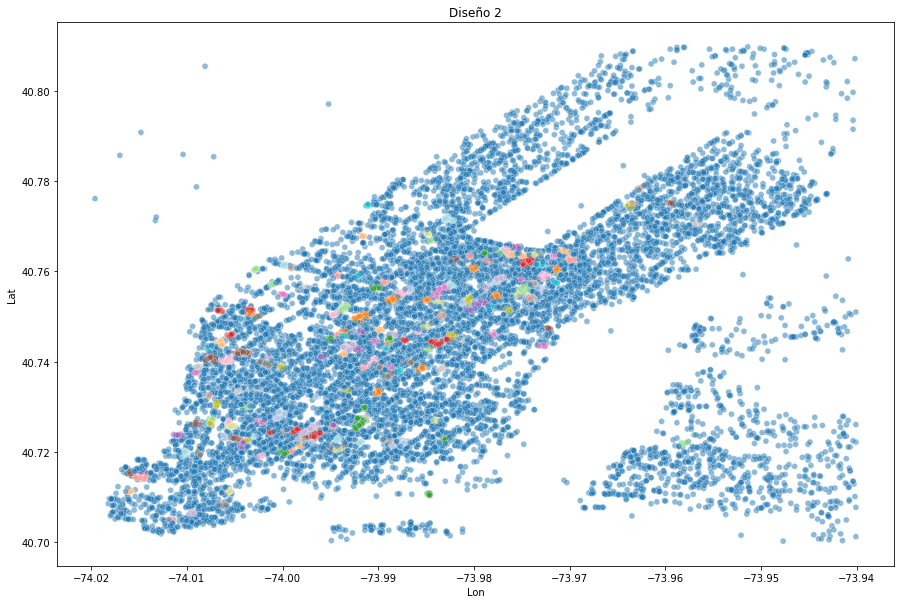

In [5]:
dat =df[['Lon', 'Lat']]

clustering = cluster.DBSCAN(eps=0.00035, min_samples=10).fit(dat)
print(len(set(clustering.labels_)))


plt.figure(figsize=(15,10))

plt.title('Diseño 2')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], palette='tab20', alpha=.5, hue=clustering.labels_)
plt.legend([],[], frameon=False)
plt.show()

191


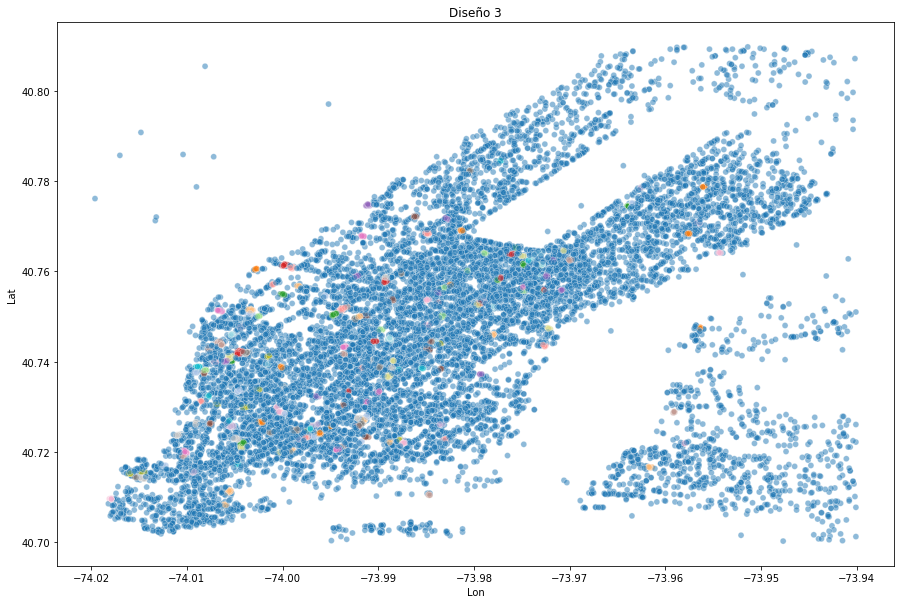

In [6]:
dat =df[['Lon', 'Lat']]
clustering = cluster.DBSCAN(eps=0.00021, min_samples=7).fit(dat)
print(len(set(clustering.labels_)))


plt.figure(figsize=(15,10))

plt.title('Diseño 3')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], palette='tab20', alpha=.5, hue=clustering.labels_)

plt.legend([],[], frameon=False)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    De cara a la redacción de la propuesta de proyecto, ¿por qué has elegido este método de agrupamiento?
</div>

En este ejercicio se pedía encontrar zonas con alta densidad de usuarios que demandan transporte público. Para eso, he utilizado el algoritmo de DBSCAN porque permite encontrar zonas con alta densidad o mucha concentración de datos. Además, los parámetros de epsilon y mínimo número de muestras me han permitido buscar zonas con una concentración de puntos relevante para esta situación.

En este caso, pretendemos suplir la demanda de Uber con transporte público. Las personas que utilizan Uber están acostumbradas a viajar solas y a recibir el servicio puerta a puerta. Por lo tanto, están acostumbradas a caminar poco y querrán que la parada este a poca distancia. Por esa razón, era necesario utilizar un algoritmo que fuera capaz de agrupar puntos que estuvieran en un rango de distancia pequeño y que permitiera escoger el número de puntos mínimo en esa distancia para que se formara un clúster. Teniendo en cuenta las características de Uber, he ideado tres posibles diseños.

Aunque los tres diseños cumplen las características formales del problema, el primer diseño contenía clústers  demasiado grandes y no tiene en cuenta que este tipo de cliente preferirá viajar en entornos con menos gente. El segundo reduce este problema y los grupos son relativamente pequeños, de manera que en las paradas no había tanta densidad de gente. Por último, en el tercer diseño los puntos son excesivamente pequeños y la rentabilidad del transporte puede quedar afectada. De manera que a mi parecer, el segundo diseño es el más apropiado para este problema porque minimiza los problemas de los otros dos diseños. En una situación real se tendrían que considerar informes económicos que consideren la viabilidad de los tres diseños. Por otro lado, puede haber un sesgo de supervivencia en los datos. Puede que algunos usuarios que no usan Uber, estuvieran interesados en usar este transporte. Por ejemplo, personas preocupadas por el medio ambiente o con rentas más bajas pueden tener más reticiencias a usar Uber. Por otro lado, no se puede pedir un Uber en Central Park, pero quizá si se podría pedir un hypermegaminiloop. La gente no pide un Uber en Central Park, no porque no quiera, sino poque no puede. Complementar estos datos con más información y otras fuentes de datos ayudarían a decidir el número de paradas y el lugar ideal para colocarlas.

### 2 b. Análisis de grupos y preparación de datos

Antes de continuar con el diseño de la red de transporte hay que validar que los grupos tienen sentido.

Lo primero es estimar la densidad de cada grupo encontrado:

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
calcula para cada cluster su área:
    <br/>
    1. Puedes simplificarla de la siguiente manera: (lat_max - lat_min) * (lon_max - lon_min), cuidado con los valores negativos, de los puntos que pertenecen al grupo.
    <br/>
    2. También calcula el número de puntos que pertenecen a cada grupo.
    <br/>
    3. Calcula el siguiente ratio: número de puntos (2) por área cubierta (1) de cada cluster.
    <br/>
    Por último, visualiza para cada cluster el resultado de este cálculo (3) en un diagrama de barras.
</div>

In [7]:
dat = df[['Lat', 'Lon']]

clustering = cluster.DBSCAN(eps=0.00035, min_samples=10).fit(dat)
dat.insert(2, 'Labels', clustering.labels_)

dat.head()

Lat      Lon  Labels
0  40.7651 -73.9615      -1
1  40.7249 -73.9947      -1
2  40.7720 -73.9590      -1
3  40.7259 -73.9905      -1
4  40.7561 -73.9731       0

In [8]:
# el label -1 no corresponde a ningún clúster, sino a datos no asignados
# y será eliminado del dataset

clus = dat.groupby('Labels').agg([min, max, 'count']).reset_index().iloc[1:]
clus.head(3)

Labels      Lat                     Lon               
              min      max count      min      max count
1      0  40.7554  40.7564    24 -73.9733 -73.9725    24
2      1  40.7505  40.7511    20 -74.0039 -74.0031    20
3      2  40.7253  40.7257    11 -73.9952 -73.9947    11

In [9]:
area = (clus['Lat']['max']-clus['Lat']['min'])*(clus['Lon']['max']+abs(clus['Lon']['min']))
area

1      8.000000e-07
2      4.800000e-07
3      2.000000e-07
4      4.800000e-07
5      2.210000e-06
           ...     
190    1.000000e-07
191    1.200000e-07
192    3.000000e-07
193    1.200000e-07
194    2.000000e-07
Length: 194, dtype: float64

In [10]:
ratio_area = area/clus['Lon']['count']
ratio_area

1      3.333333e-08
2      2.400000e-08
3      1.818182e-08
4      1.846154e-08
5      4.169811e-08
           ...     
190    1.000000e-08
191    1.500000e-08
192    2.727273e-08
193    1.200000e-08
194    1.818182e-08
Length: 194, dtype: float64

In [11]:
clus.insert(7, 'area', area)

In [12]:
clus.insert(8, 'ratio_area', ratio_area)

clus.head(10)

Labels      Lat                     Lon                         area  \
               min      max count      min      max count                 
1       0  40.7554  40.7564    24 -73.9733 -73.9725    24  8.000000e-07   
2       1  40.7505  40.7511    20 -74.0039 -74.0031    20  4.800000e-07   
3       2  40.7253  40.7257    11 -73.9952 -73.9947    11  2.000000e-07   
4       3  40.7445  40.7457    26 -73.9890 -73.9886    26  4.800000e-07   
5       4  40.7552  40.7569    53 -73.9757 -73.9744    53  2.210000e-06   
6       5  40.7613  40.7632    63 -73.9752 -73.9736    63  3.040000e-06   
7       6  40.7624  40.7630    15 -73.9704 -73.9695    15  5.400000e-07   
8       7  40.7209  40.7223    44 -74.0047 -74.0039    44  1.120000e-06   
9       8  40.7238  40.7263    62 -73.9984 -73.9961    62  5.750000e-06   
10      9  40.7413  40.7428    76 -74.0052 -74.0034    76  2.700000e-06   

      ratio_area  
                  
1   3.333333e-08  
2   2.400000e-08  
3   1.818182e-08  
4   1.846154e-08  
5   4.169811e-08  
6   4.825397e-08  
7   3.600000e-08  
8   2.545455e-08  
9   9.274194e-08  
10  3.552632e-08

In [13]:
clus.sort_values(by='ratio_area')

Labels      Lat                     Lon                         area  \
                min      max count      min      max count                 
132    131  40.7375  40.7376    11 -74.0095 -74.0089    11  6.000000e-08   
45      44  40.7603  40.7606    11 -74.0030 -74.0027    11  9.000000e-08   
83      82  40.7677  40.7680    10 -73.9918 -73.9915    10  9.000000e-08   
190    189  40.7751  40.7753    10 -73.9596 -73.9591    10  1.000000e-07   
150    149  40.7399  40.7401    10 -74.0074 -74.0069    10  1.000000e-07   
..     ...      ...      ...   ...      ...      ...   ...           ...   
41      40  40.7280  40.7290    30 -74.0008 -73.9994    30  1.400000e-06   
6        5  40.7613  40.7632    63 -73.9752 -73.9736    63  3.040000e-06   
61      60  40.7215  40.7229    35 -73.9881 -73.9868    35  1.820000e-06   
32      31  40.7545  40.7568    65 -73.9845 -73.9827    65  4.140000e-06   
9        8  40.7238  40.7263    62 -73.9984 -73.9961    62  5.750000e-06   

       ratio_area  
                   
132  5.454545e-09  
45   8.181818e-09  
83   9.000000e-09  
190  1.000000e-08  
150  1.000000e-08  
..            ...  
41   4.666667e-08  
6    4.825397e-08  
61   5.200000e-08  
32   6.369231e-08  
9    9.274194e-08  

[194 rows x 9 columns]

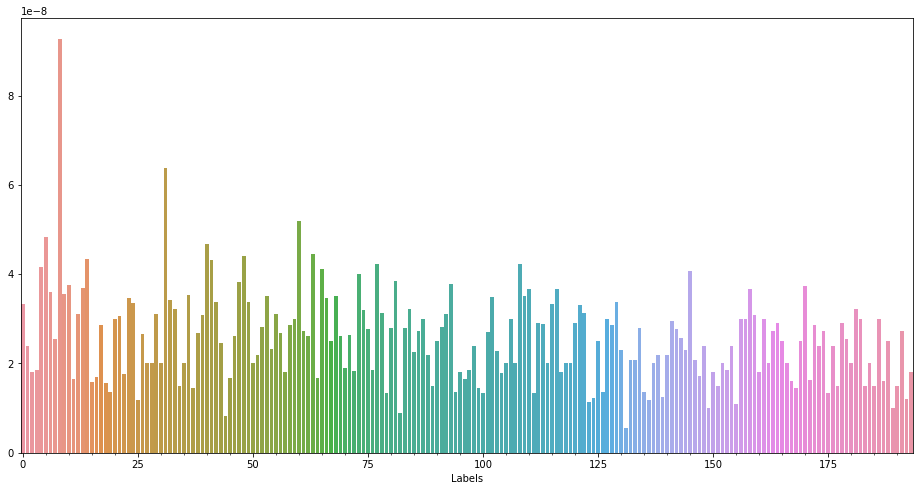

In [14]:
import matplotlib.ticker as ticker

plt.figure(figsize=(16,8))
ax = sns.barplot(x=clus['Labels'], y=ratio_area)

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    ¿Observas alguna situación sospechosa? Analízala y, si es necesario, limpia el dato para las siguientes fases.
</div>

In [15]:
def check_label(n):
    check_number = []
    for i in clustering.labels_:
        if i != n:
            i = -1
        check_number.append(i)
    return check_number            

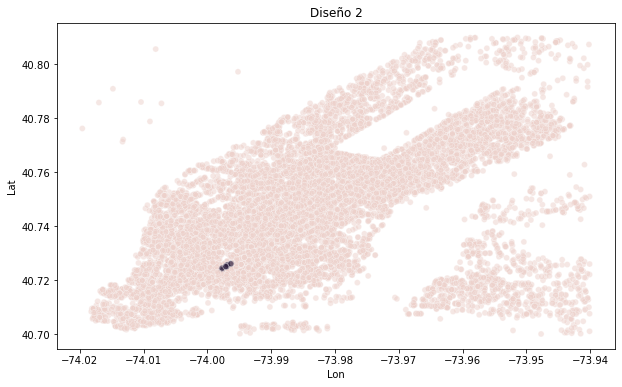

In [16]:
plt.figure(figsize=(10,6))

plt.title('Diseño 2')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], alpha=.5, hue=check_label(8))
plt.legend([],[], frameon=False)
plt.show()

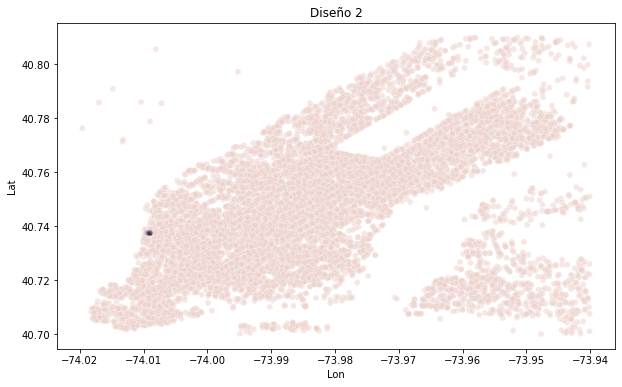

In [17]:
plt.figure(figsize=(10,6))

plt.title('Diseño 2')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], alpha=.5, hue=check_label(131))
plt.legend([],[], frameon=False)
plt.show()

Vemos que hay un outlier en la label 8. Mirando en detalle vemos como la zona está bastante desperdigada y el espacio del clúster es bastante amplio. Aún así, el área en la que están desperdigado los puntos es bastante pequeña y quien quiera coger este transporte tendrá que caminar unos pocos metros más que en otras paradas. El área sigue siendo pequeña. Por eso, no me planteo eliminar este punto.

### 2 c. Diseño de la red de transporte

Debido a que la tecnología es muy nueva y cara, tenemos el mandato de hacer un diseño que minimice la extensión de la red tratando de dar cobertura al mayor número de peticiones posibles.

Para ello se pueden usar distintas estrategias. Entre ellas la familia *MST* o [*Minimum Spanning Tree*](https://en.wikipedia.org/wiki/Minimum_spanning_tree), con algoritmos como el de [*Kruskal*](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm) o *Prim*. El algoritmo de *Kruskal* tiene la ventaja de ser muy rápido por ser *greedy* o voraz (subóptimo) y, además, evita ciclos. Un beneficio extra, ya que en nuestro caso establecería enlaces redundantes, los cuales queremos evitar por el elevado coste.

Los pasos son los siguientes:
1. Preparar los datos para el grafo.
2. Aplicar el algoritmo de Kruskal.
3. Analizar los resultados y decidir el diseño final de la red.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea un dataframe en el que haya una fila por cluster y ésta contenga: <b>id</b> del cluster (numérico), <b>latitud</b> y <b>longitud</b> (representativa del cluster), y <b>número de puntos</b> pertenecientes al cluster.
</div>

In [18]:
dat.head()

Lat      Lon  Labels
0  40.7651 -73.9615      -1
1  40.7249 -73.9947      -1
2  40.7720 -73.9590      -1
3  40.7259 -73.9905      -1
4  40.7561 -73.9731       0

In [19]:
# calculo de los valores medios de Latitud y Longitud para obtener los centroides

clust = dat.groupby(by='Labels').agg(['mean', 'count']).reset_index().iloc[1:]

clust.head()

Labels        Lat              Lon      
               mean count       mean count
1      0  40.755954    24 -73.972925    24
2      1  40.750710    20 -74.003475    20
3      2  40.725473    11 -73.995045    11
4      3  40.745042    26 -73.988785    26
5      4  40.755981    53 -73.974942    53

In [20]:
net = pd.DataFrame([])

net.insert(0, 'labels', clust.Labels)
net.insert(1, 'lat', clust['Lat']['mean'])
net.insert(2, 'lon', clust['Lon']['mean'])
net.insert(3, 'n', clust['Lat']['count'])

In [21]:
net.head()

labels        lat        lon   n
1       0  40.755954 -73.972925  24
2       1  40.750710 -74.003475  20
3       2  40.725473 -73.995045  11
4       3  40.745042 -73.988785  26
5       4  40.755981 -73.974942  53

Para crear el grafo no dirigido (si 1 está conectado con 2 se asume la dirección inversa) a partir del cual el algoritmo de *Kruskal* seleccionará los enlaces es necesario indicarle las posibles aristas del grafo.

Para crear el grafo simplemente hay que instanciar la clase `Graph` del módulo *kruskal* que hemos modificado a partir de [aquí](https://www.pythonpool.com/kruskals-algorithm-python/). Indicando en el parámetro `vertex` de su constructor el id más alto de cluster +1. Posteriormente se pueden añadir aristas al grafo indicando primero los dos ids de clusters que une el tramo y por último su peso que viene indicado por la definición de *weight* más adelante.

Por último, se calcula el resultado de *Kruskal* sobre el grafo haciendo una llamada al método `kruskal`, que también dispone de un parámetro `max_links` si sólo deseamos que se generen tantos tramos como se indiquen (útil más adelante).

Un ejemplo concreto sería el siguiente:

```
g = kruskal.Graph(vertex=5)
g.add_edge(0, 1, 8)
...
g.add_edge(3, 4, 7)
g.kruskal()
```

Debido al alto coste es necesario justificar la construcción de cada tramo del *hypermegaminiloop*, por lo que vamos a emplear una métrica que pese (*weight*) cada tramo (unión entre 2 clusters cualquiera $i$ y $j$):

$$weight(i, j) = -\frac{n_i+n_j}{dist(i, j)}$$

Donde:
 - $n_i$ es el número de puntos del cluster $i$, de la misma manera $n_j$ es el número de puntos del cluster $j$.
 - $dist(i, j)$ es la distancia geográfica en km entre el centro del cluster $i$ y el cluster $j$.
 
La distancia geográfica entre 2 puntos cualesquiera no es la distancia euclídea, puesto que la tierra tiene curvatura. Para ello puedes usar el módulo [haversine](https://pypi.org/project/haversine/) (ya importado como *hs* al inicio de la PEC).

Por último, resaltar que el peso final es negativo porque el algoritmo de *Kruskal* ve este peso como un coste que trata de minimizar. Por nuestra parte, deseamos incentivar que a medida que más alto sea el ratio descrito más atractivo le sea a *Kruskal*, por eso se hace negativo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea un grafo siguiendo el código de ejemplo en el que aparezcan todos los pares de clusters posibles (no hace falta repetir los pares porque se trata de un grafo no dirigido donde A-B también equivale a B-A), donde el peso (último parámetro del método add_edge) se calcule tal y como se describe en la fórmula de weight.
</div>

In [22]:
def edge_weight(ni:int, nj:int, lati:int,
                loni:int, latj:int, lonj:int):

    def hav_distance(lati:int, loni:int, 
                     latj:int, lonj:int):
    
        i = (lati, loni)
        j = (latj, lonj)
    
        return haversine(i, j)

    w = (ni+nj)/hav_distance(lati, loni, latj, lonj)

    return -w

In [23]:
net.head()

labels        lat        lon   n
1       0  40.755954 -73.972925  24
2       1  40.750710 -74.003475  20
3       2  40.725473 -73.995045  11
4       3  40.745042 -73.988785  26
5       4  40.755981 -73.974942  53

In [24]:
edge_weight(net.n.iloc[0], net.n.iloc[1], net.lat.iloc[0],
            net.lon.iloc[0], net.lat.iloc[1], net.lon.iloc[1])

-16.675706931773128

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
aplica el algoritmo de Kruskal llamando al método kruskal del grafo variando el número de ejes en función de tu criterio (compromiso entre extensión y coste).
</div>

In [25]:
g = kruskal.Graph(vertex=194)

for i in range(0, len(net)):
    for j in range(i+1, len(net)):
        w = edge_weight(net.n.iloc[i], net.n.iloc[j],
                        net.lat.iloc[i], net.lon.iloc[i],
                        net.lat.iloc[j], net.lon.iloc[j])
        g.add_edge(i, j, w)

In [26]:
graph = g.kruskal()

graph.head(5)

id_a  id_b      weight
0    12    69 -754.915082
1     9    12 -745.929449
2    12   149 -693.880417
3     8    85 -668.322915
4     8   145 -617.619648

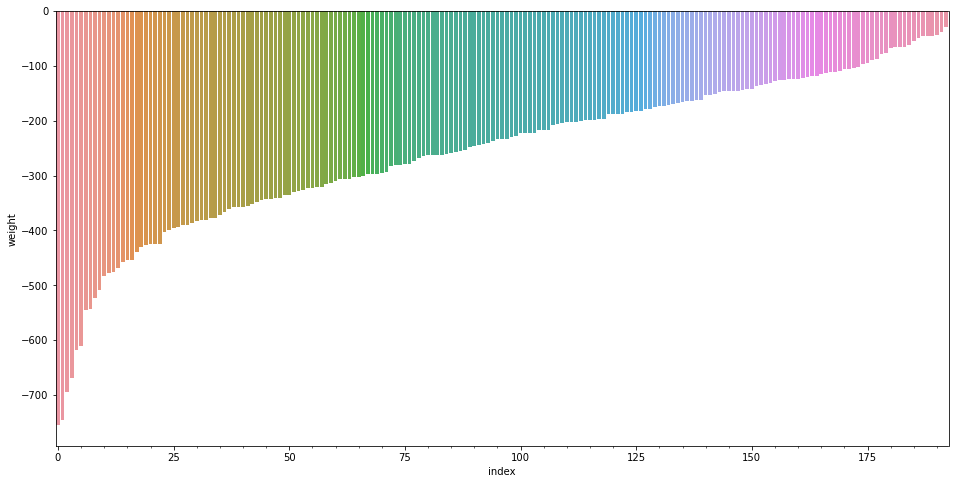

In [27]:
weight = g.kruskal()


import matplotlib.ticker as ticker

plt.figure(figsize=(16,8))
ax = sns.barplot(x=weight.reset_index()['index'],
                 y=weight.weight)

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

In [28]:
graph = g.kruskal()

graph = graph.merge(net, left_on='id_a', right_on='labels')

graph = graph.rename(columns={'lat':'lat_a', 'lon':'lon_a', 'n':'n_a'})

graph = graph.drop(columns=('labels'))

graph = graph.merge(net, left_on='id_b', right_on='labels')

graph = graph.rename(columns={'lat':'lat_b', 'lon':'lon_b', 'n':'n_b'})

graph = graph.drop(columns=('labels'))

graph.head()

id_a  id_b      weight      lat_a     lon_a  n_a      lat_b      lon_b  n_b
0    12    69 -754.915082  40.740444 -74.00569   82  40.740798 -74.007648   46
1    12   149 -693.880417  40.740444 -74.00569   82  40.739980 -74.007140   10
2    12    73 -316.369620  40.740444 -74.00569   82  40.739500 -74.001835   26
3    12    34 -296.976332  40.740444 -74.00569   82  40.738771 -74.008829   14
4    12   131 -216.798069  40.740444 -74.00569   82  40.737573 -74.009091   11

In [29]:
graph.tail()

id_a  id_b     weight      lat_a      lon_a  n_a      lat_b      lon_b  \
188    86    88 -96.862319  40.704600 -74.011655   11  40.706425 -74.009388   
189    51    55 -95.604289  40.745969 -73.978006   16  40.745967 -73.982228   
190    37    78 -54.817065  40.774745 -73.991091   11  40.771706 -73.982684   
191    39    78 -46.459467  40.779446 -73.987962   13  40.771706 -73.982684   
192   139   144 -37.873520  40.716517 -73.961608   12  40.721815 -73.958077   

     n_b  
188   16  
189   18  
190   32  
191   32  
192   13

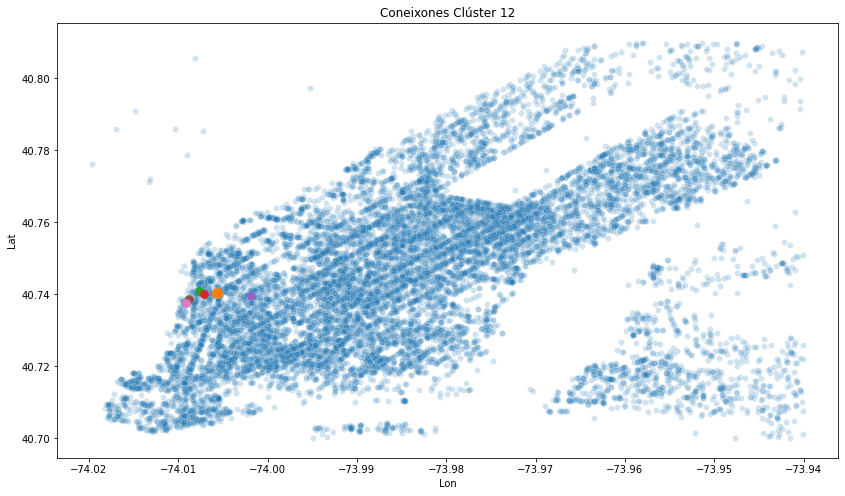

In [30]:
plt.figure(figsize=(14,8))

plt.title('Coneixones Clúster 12')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], alpha=.2)
plt.scatter(net['lon'].iloc[12], net['lat'].iloc[12], marker='o', s=100)
plt.scatter(net['lon'].iloc[69], net['lat'].iloc[69], marker='o', s=60)
plt.scatter(net['lon'].iloc[149], net['lat'].iloc[149], marker='o', s=60)
plt.scatter(net['lon'].iloc[73], net['lat'].iloc[73], marker='o', s=60)
plt.scatter(net['lon'].iloc[34], net['lat'].iloc[34], marker='o', s=60)
plt.scatter(net['lon'].iloc[131], net['lat'].iloc[131], marker='o', s=60)


plt.legend([],[], frameon=False)
plt.show()

El clúster 12 se encuentra muy próximo a otros clústers grandes y los podríamos agrupar en un mismo clúster.

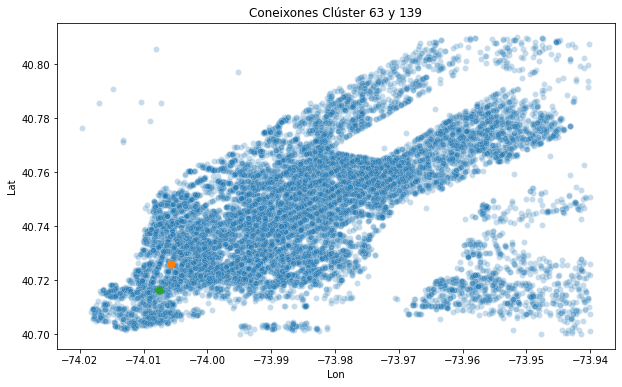

In [31]:
plt.figure(figsize=(10,6))

plt.title('Coneixones Clúster 63 y 139')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], alpha=.25)
plt.scatter(net['lon'].iloc[12], net['lat'].iloc[63], marker='o', s=50)
plt.scatter(net['lon'].iloc[69], net['lat'].iloc[139], marker='o', s=50)

plt.legend([],[], frameon=False)
plt.show()

In [32]:
graph.head(3)

id_a  id_b      weight      lat_a     lon_a  n_a      lat_b      lon_b  n_b
0    12    69 -754.915082  40.740444 -74.00569   82  40.740798 -74.007648   46
1    12   149 -693.880417  40.740444 -74.00569   82  40.739980 -74.007140   10
2    12    73 -316.369620  40.740444 -74.00569   82  40.739500 -74.001835   26

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los centros de los clusters indicando su importancia (por ejemplo incrementando su diámetro o cambiar su color en función del número de puntos que contiene) y sus enlaces indicando también su importancia (mediante su grosor o transparencia) producidos por la salida de Kruskal.
</div>

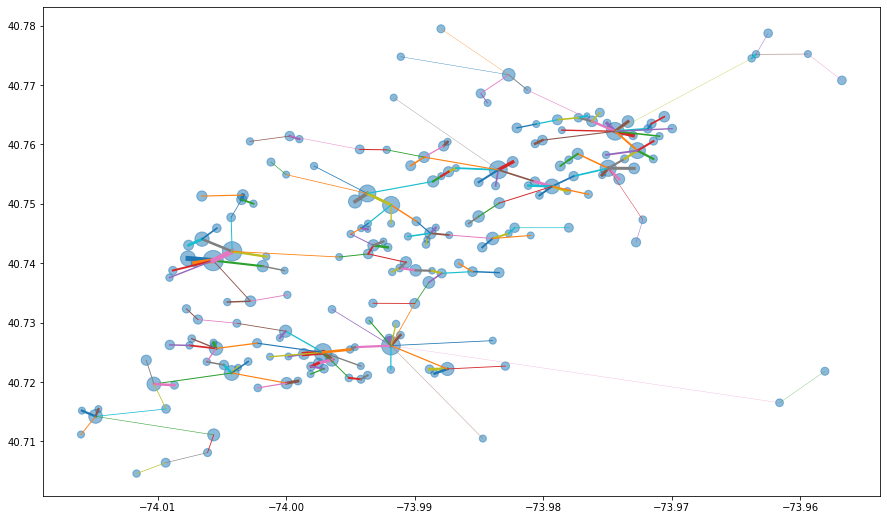

In [33]:
plt.figure(figsize=(15,9))

net.head()

plt.scatter(x=net['lon'], y=net['lat'], s=net['n']*5, alpha=.5)

for i in range(0, len(graph)):
    x = [graph['lon_a'][i], graph['lon_b'][i]] #lon
    y = [graph['lat_a'][i], graph['lat_b'][i]] #lat
    plt.plot(x, y, lw=graph['weight'][i]/graph['weight'].min()*5)

plt.show()

Vemos como el algoritmo ha sido capaz de enlazar todos los puntos recorriendo la menor distancia. Se aprecían algunas líneas distintas, pero también mucho "ruido" en las conexiones. Es decir, una misma estación se difurca en 5 distintas. Aunque esto favorece que se logre recorrer la menor distancia, es poco práctico a la hora de generar una red de transporte, porque un mismo vehiculo tendrá que volver a pasar múltiples veces por estas estaciones que tienen muchas conexiones. 

A continuación trataré de solucionar este problema para que la red de transporte sea más sencilla. Para solucionar este problema, puedo modificar el número de max_links para que no se produzcan tantas ramificaciones. Valores muy bajos generaran redes inconexas y diferentes líneas sin conexión con las demás.

A continuación voy a probar diferentes valores de links y me plantearé redefinir los clústers de esos puntos que tienen múltiples conexiones con otros puntos:

In [34]:
def graph_data(links:int, df:pd.DataFrame=net):
    graph = g.kruskal(max_links=links)
    graph = graph.merge(df, left_on='id_a', right_on='labels')
    graph = graph.rename(columns={'lat':'lat_a', 'lon':'lon_a', 'n':'n_a'})
    graph = graph.drop(columns=('labels'))
    graph = graph.merge(df, left_on='id_b', right_on='labels')
    graph = graph.rename(columns={'lat':'lat_b', 'lon':'lon_b', 'n':'n_b'})
    graph = graph.drop(columns=('labels'))
    return graph


def ny_network(graph, df:pd.DataFrame=net):
    plt.figure(figsize=(15,9))

    plt.scatter(x=df['lon'], y=df['lat'], s=df['n']*5, alpha=.5)

    for i in range(0, len(graph)):
        x = [graph['lon_a'][i], graph['lon_b'][i]] #lon
        y = [graph['lat_a'][i], graph['lat_b'][i]] #lat
        plt.plot(x, y, lw=graph['weight'][i]/graph['weight'].min()*5)

    plt.show()

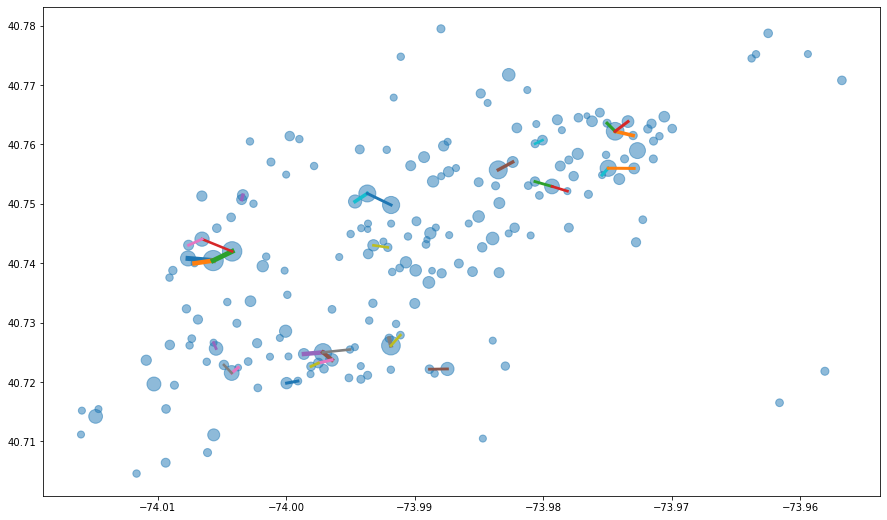

In [35]:
ny_network(graph_data(30))

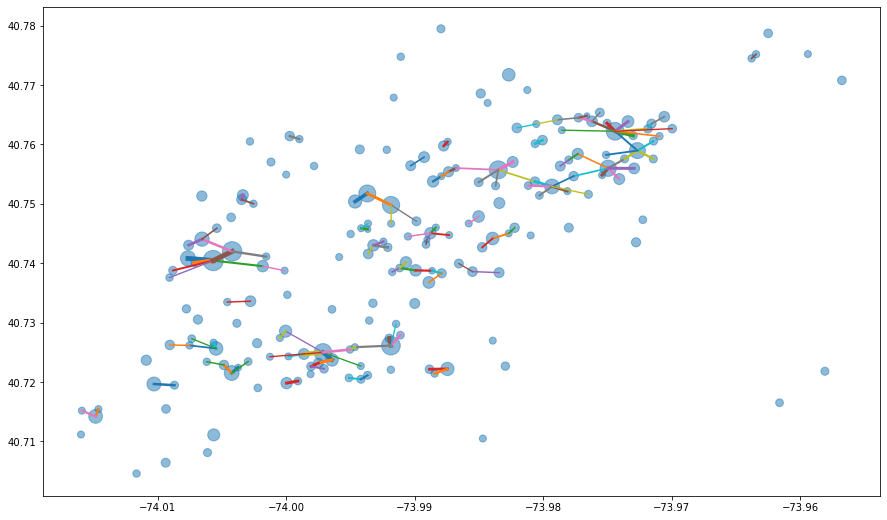

In [36]:
ny_network(graph_data(120))

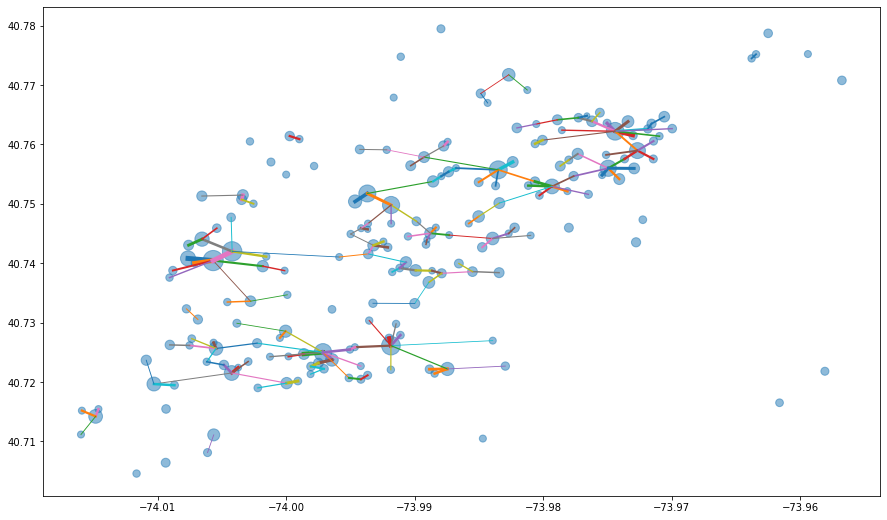

In [37]:
ny_network(graph_data(165))

Con unos 165 links se consigue agrupar la mayoría de puntos, con valores más pequeños los puntos quedan demasiado disgregados. Algunos puntos están muy alejados y no tienen conexiones con otros puntos. En estos casos, quizá lo mejor sea eliminarlos de la base de datos y que no aparezcan en el agrupamiento final. Por otro lado, sigue habiendo datos que generan muchas ramificaciones. Los puntos que salen de estas estaciones también se podrían eliminar o se podría buscar una estación que sea representativa de estos puntos estando en una localización intermedia. También hay algunos puntos que están conectados con otro punto formando una dupla inconexa.

In [38]:
graph_165 = graph_data(165)

graph_165.head()

id_a  id_b      weight      lat_a     lon_a  n_a      lat_b      lon_b  n_b
0    12    69 -754.915082  40.740444 -74.00569   82  40.740798 -74.007648   46
1    12   149 -693.880417  40.740444 -74.00569   82  40.739980 -74.007140   10
2    12    73 -316.369620  40.740444 -74.00569   82  40.739500 -74.001835   26
3    12    34 -296.976332  40.740444 -74.00569   82  40.738771 -74.008829   14
4    12   131 -216.798069  40.740444 -74.00569   82  40.737573 -74.009091   11

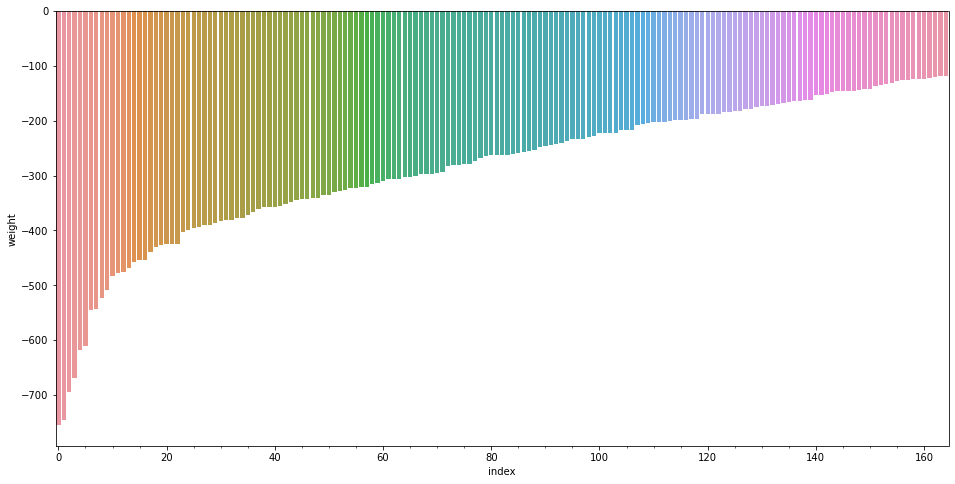

In [39]:
weight = g.kruskal(max_links=165)


import matplotlib.ticker as ticker

plt.figure(figsize=(16,8))
ax = sns.barplot(x=weight.reset_index()['index'],
                 y=weight.weight)

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

In [40]:
dots_a = list(set(graph_165.id_a))
dots_b = list(set(graph_165.id_b))
dots = list(set(dots_a + dots_b))
len(dots)

174

In [41]:
len(set(graph_165.id_b))

130

In [42]:
red_net = net.iloc[dots]

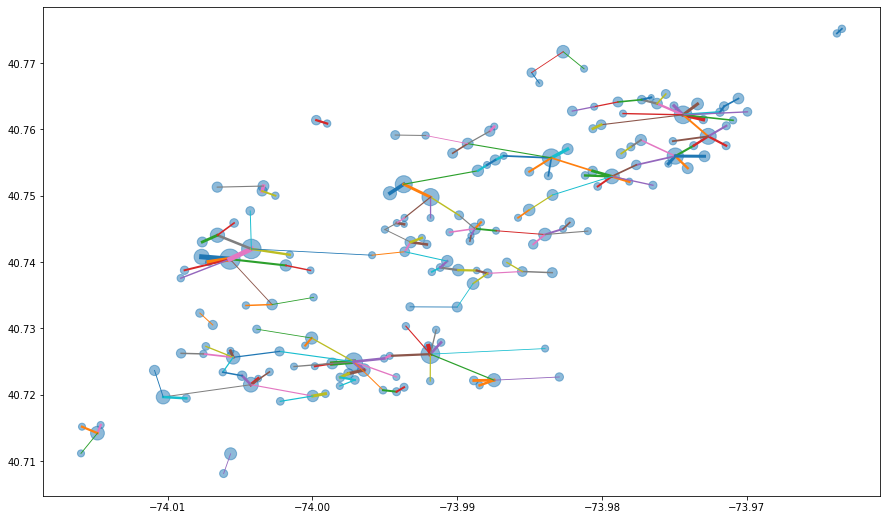

In [43]:
ny_network(graph_data(165, red_net), red_net)

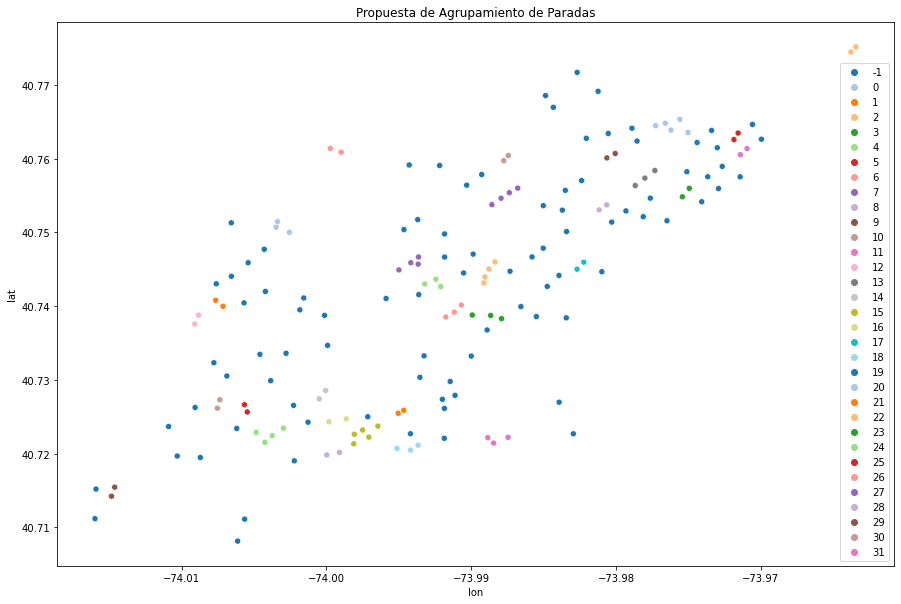

In [44]:
dat_net = red_net[['lat', 'lon']]
clustering = cluster.DBSCAN(eps=0.0013, min_samples=2).fit(dat_net)
dat_net.insert(2, 'new_labels', clustering.labels_)
dat_net.insert(2, 'labels', red_net['labels'])
dat_net.insert(3, 'n', red_net['n'])


plt.figure(figsize=(15,10))

plt.title('Propuesta de Agrupamiento de Paradas')
sns.scatterplot(x=dat_net['lon'], y=dat_net['lat'], palette='tab20', alpha=1, hue=clustering.labels_)

plt.show()

Voy a agrupar estos puntos que estaban tan juntos para reducir el nombre de estaciones con múltiples bifurcaciones.

In [45]:
red_net.head(3)

labels        lat        lon   n
1       0  40.755954 -73.972925  24
2       1  40.750710 -74.003475  20
3       2  40.725473 -73.995045  11

In [46]:
stations = dat_net.loc[dat_net['new_labels'] == -1]
stations = stations.drop(columns='new_labels')
stations.head(3)

lat        lon  labels   n
1  40.755954 -73.972925       0  24
6  40.762198 -73.974403       5  63
7  40.762647 -73.969960       6  15

In [47]:
stations_2 = dat_net.loc[dat_net['new_labels'] != -1]
stations_2 = stations_2.groupby(by='new_labels').agg(['mean', 'count', 'sum']).reset_index()

net_def = pd.DataFrame([])

net_def.insert(0, 'lat', stations_2['lat']['mean'])
net_def.insert(1, 'lon', stations_2['lon']['mean'])
net_def.insert(2, 'labels', 200 + stations_2['new_labels'])
net_def.insert(2, 'n', stations_2['n']['sum'])


net_def.head()

lat        lon   n  labels
0  40.750727 -74.003136  55     200
1  40.725671 -73.994853  21     201
2  40.744541 -73.988830  56     202
3  40.755406 -73.975181  63     203
4  40.722571 -74.003954  83     204

In [48]:
net_df = pd.concat([stations, net_def])

In [49]:
net_df.shape

(120, 4)

In [50]:
net_cl_df = net_df.reset_index().reset_index()
net_cl_df = net_cl_df.drop(columns=['labels', 'index'])
net_cl_df = net_cl_df.rename(columns={'level_0': 'labels'})
net_cl_df.head()

labels        lat        lon   n
0       0  40.755954 -73.972925  24
1       1  40.762198 -73.974403  63
2       2  40.762647 -73.969960  15
3       3  40.724994 -73.997145  62
4       4  40.741987 -74.004216  76

In [51]:
g = kruskal.Graph(vertex=120)

for i in range(0, len(net_cl_df)):
    for j in range(i+1, len(net_cl_df)):
        w = edge_weight(net_cl_df.n.iloc[i], net_cl_df.n.iloc[j],
                        net_cl_df.lat.iloc[i], net_cl_df.lon.iloc[i],
                        net_cl_df.lat.iloc[j], net_cl_df.lon.iloc[j])
        g.add_edge(i, j, w)

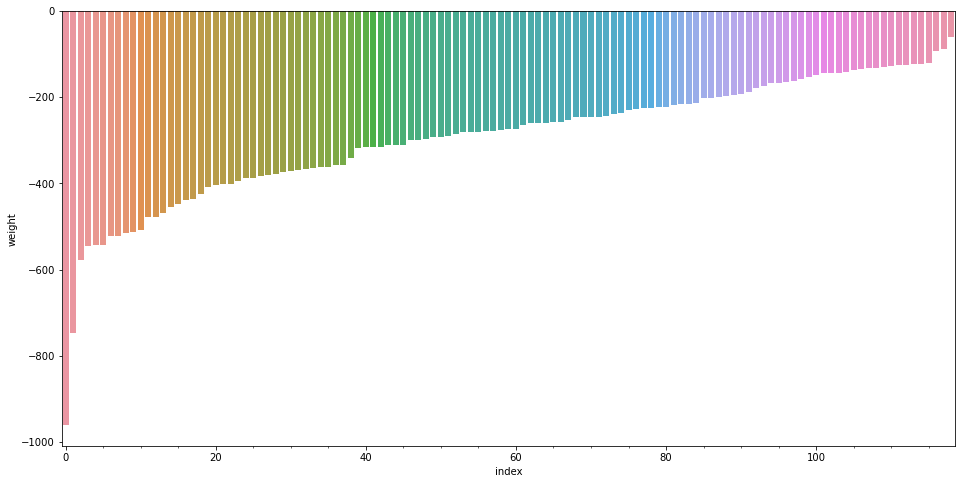

In [52]:
weight = g.kruskal()


import matplotlib.ticker as ticker

plt.figure(figsize=(16,8))
ax = sns.barplot(x=weight.reset_index()['index'],
                 y=weight.weight)

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

In [53]:
graph_cl = weight

graph_cl = graph_cl.merge(net_cl_df, left_on='id_a', right_on='labels')

graph_cl = graph_cl.rename(columns={'lat':'lat_a', 'lon':'lon_a', 'n':'n_a'})

graph_cl = graph_cl.drop(columns=('labels'))

graph_cl = graph_cl.merge(net_cl_df, left_on='id_b', right_on='labels')

graph_cl = graph_cl.rename(columns={'lat':'lat_b', 'lon':'lon_b', 'n':'n_b'})

graph_cl = graph_cl.drop(columns=('labels'))

graph_cl.head()

id_a  id_b      weight      lat_a      lon_a  n_a      lat_b      lon_b  \
0     6   109 -960.576740  40.740444 -74.005690   82  40.740389 -74.007394   
1   100   109 -289.717653  40.738172 -74.008960   25  40.740389 -74.007394   
2     6    36 -316.369620  40.740444 -74.005690   82  40.739500 -74.001835   
3     6     8 -131.431489  40.740444 -74.005690   82  40.733604 -74.002787   
4     4     6 -745.929449  40.741987 -74.004216   76  40.740444 -74.005690   

   n_b  
0   56  
1   56  
2   26  
3   23  
4   82

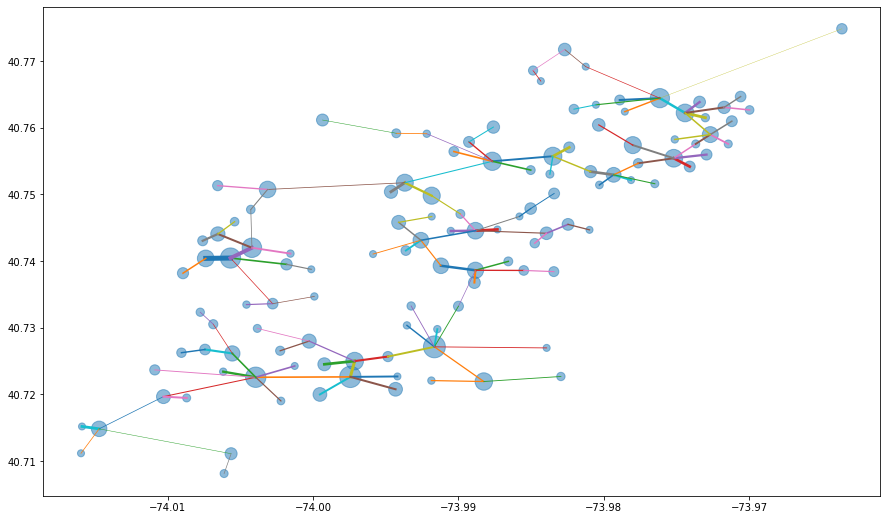

In [54]:
plt.figure(figsize=(15,9))

net.head()

plt.scatter(x=net_df['lon'], y=net_cl_df['lat'], s=net_cl_df['n']*5, alpha=.5)

for i in range(0, len(graph_cl)):
    x = [graph_cl['lon_a'][i], graph_cl['lon_b'][i]] #lon
    y = [graph_cl['lat_a'][i], graph_cl['lat_b'][i]] #lat
    plt.plot(x, y, lw=graph_cl['weight'][i]/graph_cl['weight'].min()*5)

plt.show()

In [55]:
net_cl_df.head()

labels        lat        lon   n
0       0  40.755954 -73.972925  24
1       1  40.762198 -73.974403  63
2       2  40.762647 -73.969960  15
3       3  40.724994 -73.997145  62
4       4  40.741987 -74.004216  76

In [56]:
def ny_network_text(graph, df:pd.DataFrame=net):
    plt.figure(figsize=(18,9))

    plt.scatter(x=df['lon'], y=df['lat'], s=df['n']*5, alpha=.5)

    for i in range(0, len(graph)):
        x = [graph['lon_a'][i], graph['lon_b'][i]] #lon
        y = [graph['lat_a'][i], graph['lat_b'][i]] #lat
        plt.plot(x, y, lw=graph['weight'][i]/graph['weight'].min()*5)
    for i in range(0, len(df)):
        plt.text(df['lon'][i], df['lat'][i], df['labels'][i], fontsize=16)

    plt.show()

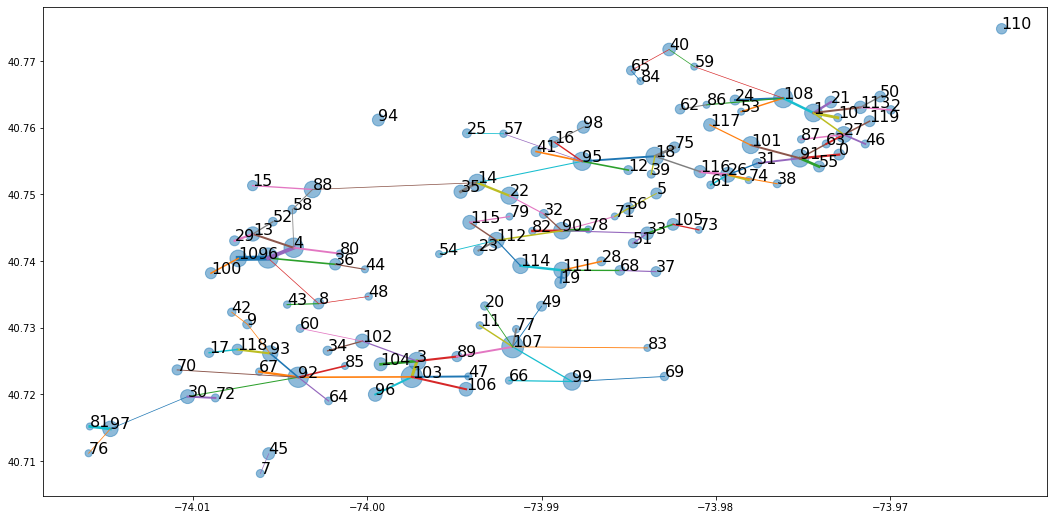

In [57]:
ny_network_text(graph_data(115, net_cl_df), net_cl_df)

In [58]:
net_cl_df

labels        lat        lon   n
0         0  40.755954 -73.972925  24
1         1  40.762198 -73.974403  63
2         2  40.762647 -73.969960  15
3         3  40.724994 -73.997145  62
4         4  40.741987 -74.004216  76
..      ...        ...        ...  ..
115     115  40.745792 -73.994116  39
116     116  40.753399 -73.980906  30
117     117  40.760406 -73.980344  32
118     118  40.726732 -74.007443  23
119     119  40.760959 -73.971185  24

[120 rows x 4 columns]

In [59]:
mydata = graph_data(115, net_cl_df)

mydata.sort_values(by=['id_a', 'weight'], ascending=True)

clusters_a = mydata['id_a']
clusters_b = mydata['id_b']

clusters = pd.concat([clusters_a, clusters_b])
clusters = clusters.value_counts()[clusters.value_counts() < 2]
clusters.head()

29     1
35     1
51     1
117    1
104    1
dtype: int64

In [60]:
mydata.head()

id_a  id_b      weight      lat_a      lon_a  n_a      lat_b      lon_b  \
0     6   109 -960.576740  40.740444 -74.005690   82  40.740389 -74.007394   
1   100   109 -289.717653  40.738172 -74.008960   25  40.740389 -74.007394   
2     6    36 -316.369620  40.740444 -74.005690   82  40.739500 -74.001835   
3     6     8 -131.431489  40.740444 -74.005690   82  40.733604 -74.002787   
4     4     6 -745.929449  40.741987 -74.004216   76  40.740444 -74.005690   

   n_b  
0   56  
1   56  
2   26  
3   23  
4   82

In [61]:
graph.head()

id_a  id_b      weight      lat_a     lon_a  n_a      lat_b      lon_b  n_b
0    12    69 -754.915082  40.740444 -74.00569   82  40.740798 -74.007648   46
1    12   149 -693.880417  40.740444 -74.00569   82  40.739980 -74.007140   10
2    12    73 -316.369620  40.740444 -74.00569   82  40.739500 -74.001835   26
3    12    34 -296.976332  40.740444 -74.00569   82  40.738771 -74.008829   14
4    12   131 -216.798069  40.740444 -74.00569   82  40.737573 -74.009091   11

In [62]:
c_list = clusters.to_frame().reset_index().iloc[:,0].to_list()

c_list

[29,
 35,
 51,
 117,
 104,
 119,
 80,
 98,
 7,
 87,
 84,
 10,
 46,
 42,
 52,
 21,
 43,
 72,
 74,
 106,
 44,
 48,
 61,
 38,
 39,
 75,
 23,
 25,
 5,
 82,
 78,
 0,
 55,
 76,
 81,
 50,
 2,
 53,
 24,
 15,
 12,
 41,
 60,
 34,
 47,
 96,
 67,
 85,
 64,
 100,
 62,
 37,
 69,
 66,
 79,
 73,
 54,
 20,
 70,
 83,
 49,
 11,
 77,
 28,
 19,
 17,
 45]

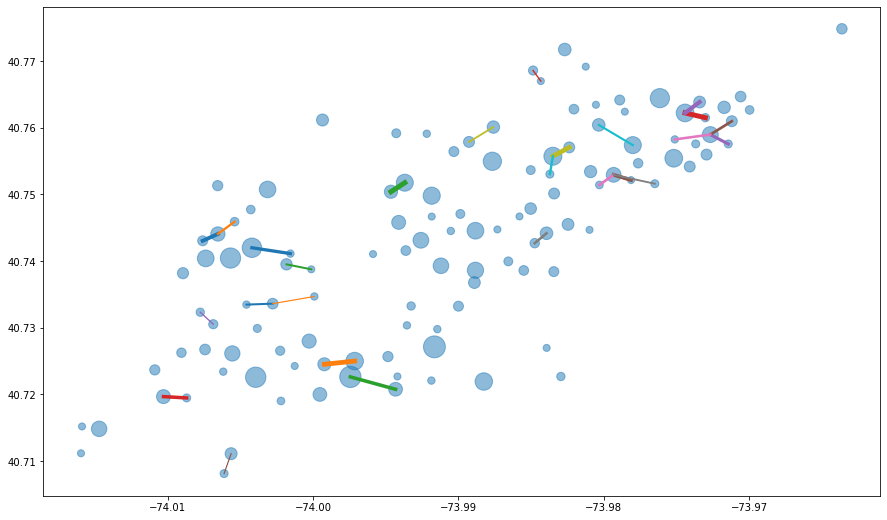

In [63]:
data = mydata.loc[mydata['id_a'].isin(c_list)]
data = mydata.loc[mydata['id_b'].isin(c_list)]

ny_network(data.reset_index(), net_cl_df)

Esta sería la línea de transporte final evitando los enlaces innecesarios y con paradas con tráfico elevado de personas.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    Además del método de Kruskal ¿se te ocurren o conoces otros métodos que podrían mejorar la solución? Descríbelo brevemente.
</div>

Una alternativa sería el Algoritmo de Prim. Empezamos en un punto del grafo, se selecciona la arista con una menor distancia a una de los puntos que ya tenemos marcados. Es decir, en vez de seleccionar una conexión cualquiera del grafo, se selecciona una conexión con el árbol que estamos generando. Esto provoca que no se puedan formar dos o más árboles inconexos como sucede con el algoritmo de Kruskal cuando ponemos un número menor al de aristas en el valor de links máximos.


REFERENCIAS:
    https://es.wikipedia.org/wiki/Algoritmo_de_Prim

## Algoritmos Genéticos.

Una manera adicional de resolver este problema es mediante el uso de algorítmos genéticos. En este caso, voy a intentar crear una pequeña línia que será el cromosoma genético. Voy a buscar crear una línea de unas 10 paradas. Como con el algoritmo anterior, se podrán crear diferenes líneas no conectadas con la línea principal. Y de la misma manera, se podrán crear estaciones de transbordo en las que hayan varias líneas.

Para hacer esto, voy a crear un DataFrame con 15 cromosmas diferentes. En un primer instante, estos cromosmas van a tener valores random del 0 al 119, estos valores serán las conexiones entre las diferentes estaciones. El valor siguiente del cromosoma será la siguiente estación. Pará saber si el algoritmo está generando una buena propuesta, generaré un weight de la suma de todas las conexiones que genera el algoritmo. 

Para calcular el weight se volverá a usar la fórmula: 
$$weight(i, j) = -\frac{n_i+n_j}{dist(i, j)}$$

Donde:
 - $n_i$ es el número de puntos del cluster $i$, de la misma manera $n_j$ es el número de puntos del cluster $j$.
 - $dist(i, j)$ es la distancia geográfica en km entre el centro del cluster $i$ y el cluster $j$.

Los cromosmas que tengan un mejor rendimiento serán los que tendrán mayor presencia en la siguiente generación y serán los "padres" en la siguiente optimización. 

La manera de hacer el crossover será mediante multipuntos. Habrá 3 cortes random entre los dos progenitores. Y se creará el nuevo cromosoma a partir de esos dos. 

Una vez se obtenga el algoritmo "descendiente" se generarán las mutaciones. Se seleccionará un gen al azar y se pondrá un alelo al azar entre las 119 posibles estaciones.

Para evitar que el algoritmo repita la misma parada de forma consecutiva, es decir que el cromosoma tenga dos genes consecutivos con el mismo valor, crearé una línea de código para que asigne un valor random a este gen.

In [64]:
def weight_(n1:int, n2:int, lat1:float, lon1:float,
            lat2:float, lon2:float) -> float:
            """Returns the weight between two locations."""

            i = (lat1, lon1)
            j = (lat2, lon2)
            dist = haversine(i, j)
            w = (n1+n2)/dist
            return w



def cromosome_weighted(cromosome:np.array, data:pd.DataFrame=net_cl_df) -> float:
    """Returns a tuple with an array and the array's weight.
    Parameters: 
                cromosome: np.array
                           Vector with the stations.
                data:      pd.DataFrame
                           The data to weight the vector.
                 """

    cromosome_stops_df = data.iloc[cromosome]
    crom_orig_dest_df = pd.DataFrame({'id O': cromosome_stops_df['labels'],
                                  'lat O': cromosome_stops_df['lat'],
                                  'lon O': cromosome_stops_df['lon'],
                                  'n O': cromosome_stops_df['n'],
                                  'id D': cromosome_stops_df['labels'].shift(periods=-1),
                                  'lat D': cromosome_stops_df['lat'].shift(periods=-1),
                                  'lon D': cromosome_stops_df['lon'].shift(periods=-1),
                                  'n D': cromosome_stops_df['n'].shift(periods=-1),
                                  }).iloc[:-1].astype({'id D': 'int32', 'n D': 'int32'})
    crom_orig_dest_df['weight'] = [weight_(i[3], i[-1], i[1], i[-3], i[2], i[-2]) for i in np.array(crom_orig_dest_df)]
    return np.round(crom_orig_dest_df['weight'].mean(), 4)



def original_cromosome(init:int, last:int, size:int, randseed=None, data:pd.DataFrame=net_cl_df) -> tuple:
    """Returns an array that corresponds to a cromosome and its weight.
    Parameters: init: int
                      Lowest possible value in the cromosome.
                last: int
                      Largest possible value of the cromosome.
                size: int
                      Size of the cromosome.
                randseed: int
                      Random seed to generate a pseudorandom vector.
                data: pd.DataFrame
                      Data to find the optimal cromosomes values.
                 """

    np.random.seed(randseed)
    cromosome = np.random.randint(low=init, high=last, size=size)
    cromosome_stops_df = data.iloc[cromosome]
    crom_orig_dest_df = pd.DataFrame({'id O': cromosome_stops_df['labels'],
                                  'lat O': cromosome_stops_df['lat'],
                                  'lon O': cromosome_stops_df['lon'],
                                  'n O': cromosome_stops_df['n'],
                                  'id D': cromosome_stops_df['labels'].shift(periods=-1),
                                  'lat D': cromosome_stops_df['lat'].shift(periods=-1),
                                  'lon D': cromosome_stops_df['lon'].shift(periods=-1),
                                  'n D': cromosome_stops_df['n'].shift(periods=-1),
                                  }).iloc[:-1].astype({'id D': 'int32', 'n D': 'int32'})
    crom_orig_dest_df['weight'] = [weight_(i[3], i[-1], i[1], i[-3], i[2], i[-2]) for i in np.array(crom_orig_dest_df)]
    cromosome[-1]
    return (cromosome, np.round(crom_orig_dest_df['weight'].mean(), 4))



def cromosome_weight_df(cromosome:np.array, data:pd.DataFrame) -> tuple:
    cromosome_stops_df = data.iloc[cromosome]
    crom_orig_dest_df = pd.DataFrame({'id O': cromosome_stops_df['labels'],
                                  'lat O': cromosome_stops_df['lat'],
                                  'lon O': cromosome_stops_df['lon'],
                                  'n O': cromosome_stops_df['n'],
                                  'id D': cromosome_stops_df['labels'].shift(periods=-1),
                                  'lat D': cromosome_stops_df['lat'].shift(periods=-1),
                                  'lon D': cromosome_stops_df['lon'].shift(periods=-1),
                                  'n D': cromosome_stops_df['n'].shift(periods=-1),
                                  }).iloc[:-1].astype({'id D': 'int32', 'n D': 'int32'})
    crom_orig_dest_df['weight'] = [weight_(i[3], i[-1], i[1], i[-3], i[2], i[-2]) for i in np.array(crom_orig_dest_df)]
    return (cromosome, np.round(crom_orig_dest_df['weight'].mean(), 4))



original_cromosome(0, 119, 10, 12, net_cl_df)

(array([ 75,  27,   6, 113,   2,   3,  67,  76,  48,  22]), 0.0046)

In [65]:
cromosome_weighted(original_cromosome(0, 119, 10, 12, net_cl_df)[0])

0.0046

In [66]:
def crossover(last:int, size:int, n_cromosomes:int):
    crossover = []
    for i in range(1, n_cromosomes):
        cutpoint = np.random.randint(0, size)
        cros = np.append(cromosomes[i-1][:cutpoint], cromosomes[i][cutpoint:])
        loc_mutation = np.random.randint(0, size)
        cros[loc_mutation] = np.random.randint(0, last)
        crossover.append(cros)

    # en caso de que haya un cromosoma que repita estaciones de forma consecutiva, la segunda estación se asignará a la siguiente
    for ic in range(0, n_cromosomes-1):
        yloc = 0
        for x, y in zip(crossover[ic], crossover[ic][1:]):
            yloc += 1
            if x == y:
                crossover[ic][yloc] += 1
    return crossover

In [67]:
def first_gen(init:int, last:int, size:int, n_cromosomes:int, randseed=None, data:pd.DataFrame=net_cl_df) -> list:
    weights_list = []
    weights_sum = 0
    cromosomes = []

    # se crean n cromosomas con valores aleatorios y se guardan en una lista
    for i in range(0, n_cromosomes):
        x = original_cromosome(init, last, size, randseed, net_cl_df)
        cromosomes.append(x[0])
        weights_list.append(x[1])
        weights_sum += x[1]

    # se calcula el rendimiento de cada uno
    fitness_cromosome = weights_list/weights_sum

    # se suma el fitness de cada cromosoma de manera aditiva
    sum_fitness = 0
    fitness_proportion = np.array([])
    for i in fitness_cromosome:
        sum_fitness += i
        fitness_proportion = np.append(fitness_proportion, sum_fitness)

    # seleccionamos los padres para hacer el corssover de manera aleatoria 
    selection = np.random.uniform(0, 1, n_cromosomes)
    parents_id = []
    for s in selection:
        n = 0
        for f in fitness_proportion:
            n += 1
            if s < f:
                parents_id.append(n)
                break

    # se emparejan los cromosomas con un cutpoint random y se añade una mutación
    crossover = []
    for i in range(1, n_cromosomes):
        cutpoint = np.random.randint(0, size)
        cros = np.append(cromosomes[i-1][:cutpoint], cromosomes[i][cutpoint:])
        loc_mutation = np.random.randint(0, size)
        cros[loc_mutation] = np.random.randint(0, last)
        crossover.append(cros)

    # en caso de que haya un cromosoma que repita estaciones de forma consecutiva, se cambia la 2a
    for ic in range(0, n_cromosomes-1):
        yloc = 0
        for x, y in zip(crossover[ic], crossover[ic][1:]):
            yloc += 1
            if x == y:
                crossover[ic][yloc] += 1
    return crossover
    
def generation(list_crom: list, last:int, data:pd.DataFrame=net_cl_df) -> list:

    cromosomes = list_crom
    n_cromosomes = len(list_crom)
    size = list_crom[0].shape[0]

    weights_list = []
    weights_sum = 0
    for cromosome in cromosomes:
        crom_weight = cromosome_weighted(cromosome, data=data)
        weights_list.append(crom_weight)
        weights_sum += crom_weight

    # se calcula el rendimiento de cada uno
    fitness_cromosome = weights_list/weights_sum

    # se suma el fitness de cada cromosoma de manera aditiva
    sum_fitness = 0
    fitness_proportion = np.array([])
    for i in fitness_cromosome:
        sum_fitness += i
        fitness_proportion = np.append(fitness_proportion, sum_fitness)

    # seleccionamos los padres para hacer el corssover de manera aleatoria 
    selection = np.random.uniform(0, 1, n_cromosomes)
    parents_id = []
    for s in selection:
        n = 0
        for f in fitness_proportion:
            n += 1
            if s < f:
                parents_id.append(n)
                break

    # se emparejan los cromosomas con un cutpoint random y se añade una mutación
    crossover = []

    # para que el último cromosoma se pueda emparejar, pongo el primero último
    cromosomes.append(cromosomes[0])
    for i in range(1, n_cromosomes+1):
        cutpoint = np.random.randint(0, size)
        cros = np.append(cromosomes[i-1][:cutpoint], cromosomes[i][cutpoint:])
        loc_mutation = np.random.randint(0, size)
        cros[loc_mutation] = np.random.randint(0, last)
        crossover.append(cros)

    # en caso de que haya un cromosoma que repita estaciones de forma consecutiva, se cambia la 2a
    for ic in range(0, n_cromosomes-1):
        yloc = 0
        for x, y in zip(crossover[ic], crossover[ic][1:]):
            yloc += 1
            if x == y:
                crossover[ic][yloc] += 1
    
    return crossover

In [68]:
def elitism_ga(list_crom: list, last:int, data:pd.DataFrame=net_cl_df) -> list:
    """Returns a generation in a list of array using elitism."""

    cromosomes = list_crom
    n_cromosomes = len(list_crom)
    size = list_crom[0].shape[0]

    weights_list = []
    weights_sum = 0
    # if an individual has the same cromosome twice, it would have a very low weight to not be selected
    for cromosome in cromosomes:
        if len(cromosome) == len(set(cromosome)):
            crom_weight = cromosome_weighted(cromosome, data=data)
        else:
            crom_weight = 0.000001
        weights_list.append(crom_weight)
        weights_sum += crom_weight

    # se calcula el rendimiento de cada uno
    fitness_cromosome = weights_list/weights_sum

    # se suma el fitness de cada cromosoma de manera aditiva
    sum_fitness = 0
    fitness_proportion = np.array([])
    for i in fitness_cromosome:
        sum_fitness += i
        fitness_proportion = np.append(fitness_proportion, sum_fitness)

    # seleccionamos los padres para hacer el corssover de manera aleatoria 
    selection = np.random.uniform(0, 1, n_cromosomes)
    parents_id = []
    for s in selection:
        n = 0
        for f in fitness_proportion:
            n += 1
            if s < f:
                parents_id.append(n)
                break

    # se emparejan los cromosomas con un cutpoint random y se añade una mutación
    crossover = []

    # elitismo: añado el mejor cromosoma de la generación anterior sin variaciones
    crossover.append(cromosomes[weights_list.index(max(weights_list))])

    # para que el último cromosoma se pueda emparejar, pongo el primero último
    for i in range(1, n_cromosomes):
        cutpoint = np.random.randint(0, size)
        cros = np.append(cromosomes[i-1][:cutpoint], cromosomes[i][cutpoint:])
        loc_mutation = np.random.randint(0, size)
        cros[loc_mutation] = np.random.randint(0, last)
        crossover.append(cros)

    # en caso de que haya un cromosoma que repita estaciones de forma consecutiva, se cambia la 2a
    for ic in range(0, n_cromosomes-1):
        yloc = 0
        for x, y in zip(crossover[ic], crossover[ic][1:]):
            yloc += 1
            if x == y:
                crossover[ic][yloc] += 1

    return crossover



def plot_genetetic_alg(x=np.array, data:pd.DataFrame=net_cl_df):
    genetic_labels_df = data.iloc[x]
    dest_df = genetic_labels_df

    orig_df = genetic_labels_df[:-1].rename(columns={'labels':'id_a', 'lat':'lat_a',
                                                 'lon': 'lon_a', 'n': 'n_a'})
    orig_df = orig_df.reset_index().drop(columns=['index']).reset_index()

    dest_df = genetic_labels_df.shift(-1)[:-1].rename(columns={'labels':'id_b', 'lat':'lat_b',
                                                           'lon': 'lon_b', 'n': 'n_b'}).reset_index().drop(columns=['index'])
    dest_df = dest_df.reset_index().drop(columns=['index']).reset_index()
    dest_orig_gen_df = orig_df.merge(dest_df, on='index').drop(columns=['index'])
    plt.figure(figsize=(15,9))
    plt.scatter(x=net_cl_df['lon'], y=net_cl_df['lat'], s=net_cl_df['n']*5, alpha=.5)
    for i in range(0, len(dest_orig_gen_df)):
        x = [dest_orig_gen_df['lon_a'][i], dest_orig_gen_df['lon_b'][i]] #lon
        y = [dest_orig_gen_df['lat_a'][i], dest_orig_gen_df['lat_b'][i]] #lat
        #plt.plot(x, y, lw=dest_orig_gen_df['weight'][i]/dest_orig_gen_df['weight'].min()*5)
        plt.plot(x, y)

    plt.show()
    

In [69]:
fg = first_gen(init=0, last=119, size=10, n_cromosomes=20, randseed=None, data=net_cl_df)
fg[:5]

[array([ 74,  12, 115,  62, 110, 114,   1,  65,  29,  32]),
 array([ 55,  35,  26,  87, 110, 114,  85,   3,  24,  89]),
 array([64, 75,  0, 83,  8, 76, 56, 83, 99, 64]),
 array([115,  86,  85,  46,  13, 112,  83,  91,  73,  57]),
 array([  6,  60,  75,  46,  10,  15, 112,  37,   3, 114])]

In [70]:
fg = first_gen(init=0, last=119, size=10, n_cromosomes=300, randseed=None, data=net_cl_df)

x = fg

for i in range(0, 30):
    x = generation(x, 119)

x

[array([ 46,  14,  49,  11,  76,  52,  18, 109,  14,  88]),
 array([60, 59, 49,  5, 26, 40, 24, 22, 63,  8]),
 array([ 25,  10,  41,  25,  26,  59,  66,  21,  41, 106]),
 array([ 25,  10,  17,  25,  26, 118,  66,  21,  41,   9]),
 array([ 85,  47, 102,  14,  15, 117,   7,  82, 111,  56]),
 array([ 52,  47,  55,  96,  72, 117,  59,  40,  83,  92]),
 array([ 24,  18,  55,  96,  72, 117,  59,  82,  74,   0]),
 array([ 75,  39, 102,  96,  71,  38,  59, 111,  74,  53]),
 array([113, 116, 115,  60,  71,  62, 107,  86, 105,  36]),
 array([ 60,  74,  42,  60,  77,  62, 107,  87, 105,   2]),
 array([ 60,  22,  42,  60,  77,  67, 107,  87,  70, 104]),
 array([ 98,   9,  25, 101,  55,  79,  40,  76,  15,   4]),
 array([ 98,  32,  25, 101,  55,  79,  49, 106,  30,  88]),
 array([ 88, 106, 108, 101,  55,  79,  49,  64,  88,  92]),
 array([ 39,  81,  20,  92,  41,  81,  73,  64,   8, 109]),
 array([ 21,  81,  40,  87,  41,  61,  62,  13,   8, 112]),
 array([ 82,  94,   1,  87, 115,  81,  61,  13,   

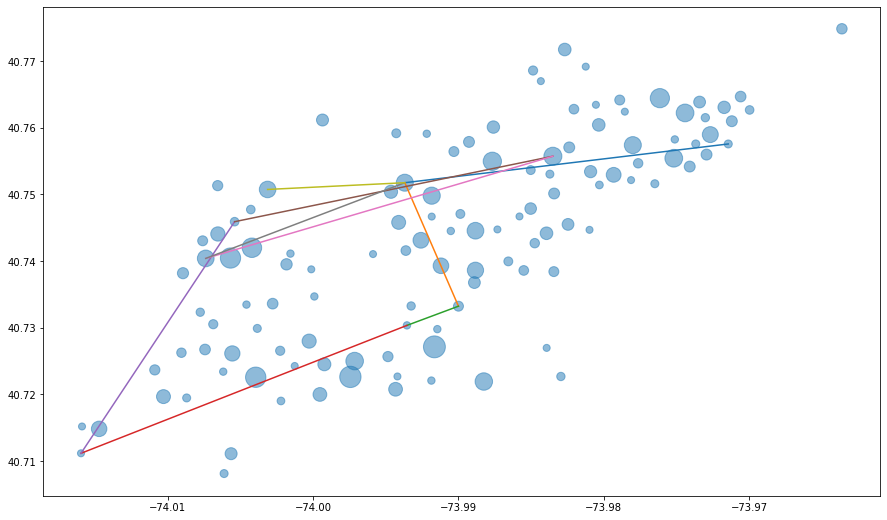

In [71]:
plot_genetetic_alg(x[0])

In [72]:
fg = first_gen(init=0, last=119, size=10, n_cromosomes=20, randseed=None, data=net_cl_df)

elit_alg = fg

for i in range(0, 30):
    elit_alg = elitism_ga(elit_alg, 119)

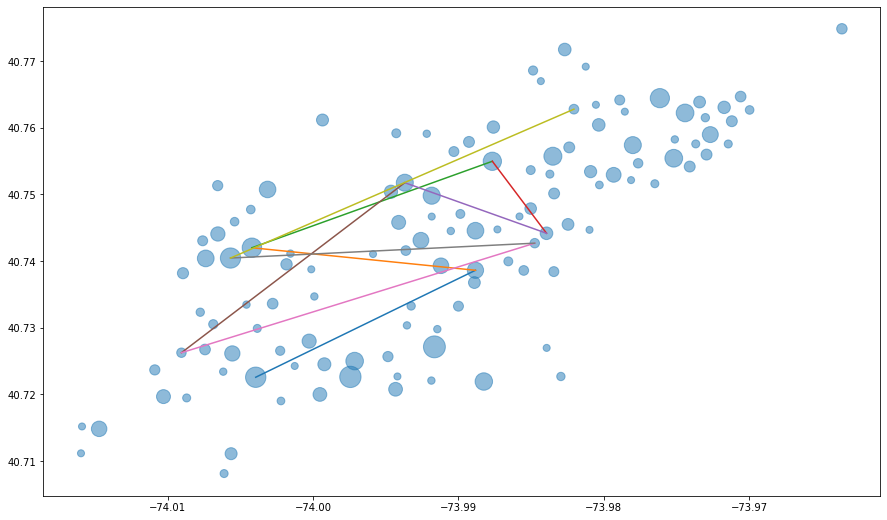

In [73]:
plot_genetetic_alg(elit_alg[0])

The previous genetic algorithm has found great station, but the order of the stations can be optimized even more. To find the best combination between the stations and generate a more efficient railway, we van use another genetic algorithm to reduce the total distance of the line.


## Distance Genethic Algorithm

In [74]:
len(elit_alg[0])

10

In [75]:
init_crom = elit_alg[0]
numbercrom = len(init_crom)
npopulation = 20
archivelen = 20
data = net_cl_df

# generates the first full population randomly
from numpy.random import default_rng
rng = default_rng()
population = [rng.choice(numbercrom, numbercrom, replace=False)
 for i in range(0, npopulation)]
population

[array([9, 2, 6, 3, 7, 5, 1, 0, 4, 8], dtype=int64),
 array([2, 6, 1, 5, 0, 4, 9, 7, 3, 8], dtype=int64),
 array([9, 6, 8, 3, 1, 0, 7, 2, 4, 5], dtype=int64),
 array([8, 7, 5, 4, 0, 6, 2, 1, 3, 9], dtype=int64),
 array([8, 7, 9, 0, 6, 5, 3, 4, 1, 2], dtype=int64),
 array([5, 3, 7, 6, 8, 9, 2, 4, 1, 0], dtype=int64),
 array([2, 8, 9, 5, 7, 3, 1, 4, 0, 6], dtype=int64),
 array([8, 7, 9, 4, 1, 2, 0, 6, 3, 5], dtype=int64),
 array([5, 1, 8, 3, 2, 6, 9, 7, 0, 4], dtype=int64),
 array([4, 1, 5, 6, 3, 2, 9, 0, 7, 8], dtype=int64),
 array([1, 9, 4, 2, 8, 7, 5, 0, 6, 3], dtype=int64),
 array([2, 1, 3, 8, 7, 5, 0, 4, 9, 6], dtype=int64),
 array([0, 1, 6, 2, 7, 5, 9, 8, 3, 4], dtype=int64),
 array([6, 2, 1, 0, 4, 7, 3, 9, 8, 5], dtype=int64),
 array([0, 7, 8, 5, 6, 9, 2, 3, 4, 1], dtype=int64),
 array([4, 3, 1, 9, 5, 0, 6, 8, 2, 7], dtype=int64),
 array([9, 6, 4, 1, 3, 2, 7, 5, 8, 0], dtype=int64),
 array([7, 9, 2, 3, 6, 1, 5, 4, 0, 8], dtype=int64),
 array([1, 0, 5, 4, 2, 6, 9, 3, 7, 8], dtype=i

In [76]:
# 1. rename the labels to 0 to len(array)
# as not need it, the n column is erased

dist = data.iloc[init_crom, :-1].reset_index(drop=True)
dist

labels        lat        lon
0      92  40.722571 -74.003954
1     111  40.738610 -73.988830
2       4  40.741987 -74.004216
3      95  40.754951 -73.987669
4      33  40.744159 -73.983941
5      14  40.751738 -73.993693
6      17  40.726250 -74.009067
7      51  40.742672 -73.984750
8       6  40.740444 -74.005690
9      62  40.762763 -73.982053

In [77]:
population[0]

orig = dist.iloc[population[0][1]]

orig.lat

40.74198684210526

In [78]:
individual = population[0]
location = 0
orig = dist.iloc[[individual][location]]

In [79]:
dist.iloc[individual[location]]

labels    62.000000
lat       40.762763
lon      -73.982053
Name: 9, dtype: float64

In [80]:
for individual in population:
    distance = 0
    for location in range(0, numbercrom-1):
        orig = dist.iloc[individual[location]]
        dest = dist.iloc[individual[location+1]]
        i = (orig.lat, orig.lon)
        j = (dest.lat, dest.lon)
        distance += haversine(i, j)
        

distance

21.803107390642765

In [81]:
population

[array([9, 2, 6, 3, 7, 5, 1, 0, 4, 8], dtype=int64),
 array([2, 6, 1, 5, 0, 4, 9, 7, 3, 8], dtype=int64),
 array([9, 6, 8, 3, 1, 0, 7, 2, 4, 5], dtype=int64),
 array([8, 7, 5, 4, 0, 6, 2, 1, 3, 9], dtype=int64),
 array([8, 7, 9, 0, 6, 5, 3, 4, 1, 2], dtype=int64),
 array([5, 3, 7, 6, 8, 9, 2, 4, 1, 0], dtype=int64),
 array([2, 8, 9, 5, 7, 3, 1, 4, 0, 6], dtype=int64),
 array([8, 7, 9, 4, 1, 2, 0, 6, 3, 5], dtype=int64),
 array([5, 1, 8, 3, 2, 6, 9, 7, 0, 4], dtype=int64),
 array([4, 1, 5, 6, 3, 2, 9, 0, 7, 8], dtype=int64),
 array([1, 9, 4, 2, 8, 7, 5, 0, 6, 3], dtype=int64),
 array([2, 1, 3, 8, 7, 5, 0, 4, 9, 6], dtype=int64),
 array([0, 1, 6, 2, 7, 5, 9, 8, 3, 4], dtype=int64),
 array([6, 2, 1, 0, 4, 7, 3, 9, 8, 5], dtype=int64),
 array([0, 7, 8, 5, 6, 9, 2, 3, 4, 1], dtype=int64),
 array([4, 3, 1, 9, 5, 0, 6, 8, 2, 7], dtype=int64),
 array([9, 6, 4, 1, 3, 2, 7, 5, 8, 0], dtype=int64),
 array([7, 9, 2, 3, 6, 1, 5, 4, 0, 8], dtype=int64),
 array([1, 0, 5, 4, 2, 6, 9, 3, 7, 8], dtype=i

In [82]:
def individual_distance(individual):
    distance = 0
    for location in range(0, numbercrom-1):
        orig = dist.iloc[individual[location]]
        dest = dist.iloc[individual[location+1]]
        i = (orig.lat, orig.lon)
        j = (dest.lat, dest.lon)
        distance += haversine(i, j)
    return distance



def generation_distances(population):
    list_distances = []
    for individual in population:
        list_distances.append((individual_distance(individual)))
    return list_distances



def archive(population):
    return pd.DataFrame({'population': population,
                        'distance': generation_distances(population)}
                        ).sort_values(by=['distance']
                        ).reset_index(drop=True).iloc[:archivelen]

In [83]:
generation_distances(population)

[19.598386143364625,
 19.715915053881453,
 19.787952189418565,
 13.69986808452802,
 16.524691149201235,
 17.167147506403385,
 13.698456311790515,
 15.232348557804531,
 21.561463931208685,
 23.391008451849178,
 17.413313901855858,
 21.443490184444357,
 17.28618812431041,
 15.621150523819773,
 20.881165736191058,
 14.78333849826004,
 18.632644706806786,
 20.695852128894842,
 19.059693752333413,
 21.803107390642765]

In [84]:
archivelen = 20
archive = archive(population)

archive.head()

population   distance
0  [2, 8, 9, 5, 7, 3, 1, 4, 0, 6]  13.698456
1  [8, 7, 5, 4, 0, 6, 2, 1, 3, 9]  13.699868
2  [4, 3, 1, 9, 5, 0, 6, 8, 2, 7]  14.783338
3  [8, 7, 9, 4, 1, 2, 0, 6, 3, 5]  15.232349
4  [6, 2, 1, 0, 4, 7, 3, 9, 8, 5]  15.621151

In [85]:
new_population = []
for individual in archive.population:
    new_population.append(individual)

    i = copy.deepcopy(individual)

    # choose location cromosomes
    p1 = np.random.randint(1, numbercrom)
    p2 = np.random.randint(1, numbercrom)

    # stores the values to interchange
    cr1 = i[p1]
    cr2 = i[p2]

    # create mutated individual  
    i[p1] = cr2
    i[p2] = cr1

    new_population.append(i)

new_population

[array([2, 8, 9, 5, 7, 3, 1, 4, 0, 6], dtype=int64),
 array([2, 8, 9, 5, 7, 1, 3, 4, 0, 6], dtype=int64),
 array([8, 7, 5, 4, 0, 6, 2, 1, 3, 9], dtype=int64),
 array([8, 7, 5, 4, 0, 2, 6, 1, 3, 9], dtype=int64),
 array([4, 3, 1, 9, 5, 0, 6, 8, 2, 7], dtype=int64),
 array([4, 3, 1, 9, 5, 0, 6, 8, 2, 7], dtype=int64),
 array([8, 7, 9, 4, 1, 2, 0, 6, 3, 5], dtype=int64),
 array([8, 7, 9, 4, 1, 2, 0, 3, 6, 5], dtype=int64),
 array([6, 2, 1, 0, 4, 7, 3, 9, 8, 5], dtype=int64),
 array([6, 2, 1, 0, 4, 7, 3, 9, 8, 5], dtype=int64),
 array([8, 7, 9, 0, 6, 5, 3, 4, 1, 2], dtype=int64),
 array([8, 7, 0, 9, 6, 5, 3, 4, 1, 2], dtype=int64),
 array([5, 3, 7, 6, 8, 9, 2, 4, 1, 0], dtype=int64),
 array([5, 3, 7, 4, 8, 9, 2, 6, 1, 0], dtype=int64),
 array([0, 1, 6, 2, 7, 5, 9, 8, 3, 4], dtype=int64),
 array([0, 1, 6, 2, 7, 5, 9, 8, 4, 3], dtype=int64),
 array([1, 9, 4, 2, 8, 7, 5, 0, 6, 3], dtype=int64),
 array([1, 9, 4, 2, 8, 5, 7, 0, 6, 3], dtype=int64),
 array([9, 6, 4, 1, 3, 2, 7, 5, 8, 0], dtype=i

In [86]:
len(new_population)

40

In [87]:
archive = pd.DataFrame({'population': new_population,
                        'distance': generation_distances(new_population)}
                        ).sort_values(by=['distance']
                        ).reset_index(drop=True).iloc[:archivelen]

archive.head()

population   distance
0  [2, 8, 9, 5, 7, 1, 3, 4, 0, 6]  13.377241
1  [2, 8, 9, 5, 7, 3, 1, 4, 0, 6]  13.698456
2  [8, 7, 5, 4, 0, 6, 2, 1, 3, 9]  13.699868
3  [4, 1, 5, 9, 3, 2, 6, 0, 7, 8]  13.754261
4  [4, 3, 1, 9, 5, 0, 6, 8, 2, 7]  14.783338

In [88]:
len(generation_distances(new_population))

40

In [89]:
print(archive.population[0])



[2 8 9 5 7 1 3 4 0 6]


In [91]:
p1 = np.random.randint(1, numbercrom)
p2 = np.random.randint(1, numbercrom)

print(p1, p2)

9 3


In [93]:
def distance_genetic(init_crom=elit_alg[0], npopulation=20, archivelen=20, generations=20, data = net_cl_df):
    def individual_distance(individual):
        distance = 0
        for location in range(0, numbercrom-1):
            orig = dist.iloc[individual[location]]
            dest = dist.iloc[individual[location+1]]
            i = (orig.lat, orig.lon)
            j = (dest.lat, dest.lon)
            distance += haversine(i, j)
        return distance



    def generation_distances(population):
        list_distances = []
        for individual in population:
            list_distances.append((individual_distance(individual)))
        return list_distances



    def generate_archive(population):
        return pd.DataFrame({'population': population,
                            'distance': generation_distances(population)}
                            ).sort_values(by=['distance']
                            ).reset_index(drop=True).iloc[:archivelen]



    # due to the data, there will not be crossover
    def new_gen(archive):
        new_population = []
        for individual in archive.population:
            new_population.append(individual)

            i = copy.deepcopy(individual)

            # choose location cromosomes
            p1 = np.random.randint(1, numbercrom)
            p2 = np.random.randint(1, numbercrom)

            # stores the values to interchange
            cr1 = i[p1]
            cr2 = i[p2]

            # create mutated individual  
            i[p1] = cr2
            i[p2] = cr1

            new_population.append(i)
        
        return generate_archive(new_population)



    numbercrom = len(init_crom)

    # generates the first full population randomly
    from numpy.random import default_rng
    rng = default_rng()
    population = [rng.choice(numbercrom, numbercrom, replace=False)
     for i in range(0, npopulation)]

     # 1. rename the labels to 0 to len(array)
    # as not need it, the n column is erased

    dist = data.iloc[init_crom, 1:-1].reset_index(drop=True)

    archive = generate_archive(population)

    for i in range(0, generations):
        archive = new_gen(archive)

    # recode the stations to their correct id
    ids = data.iloc[init_crom, :-1].reset_index(drop=True)
    best_individual = archive.iloc[0]
    return archive, ids.iloc[best_individual.population].labels.to_numpy()


archive, alg = distance_genetic()

In [94]:
archive, alg = distance_genetic(generations=12)

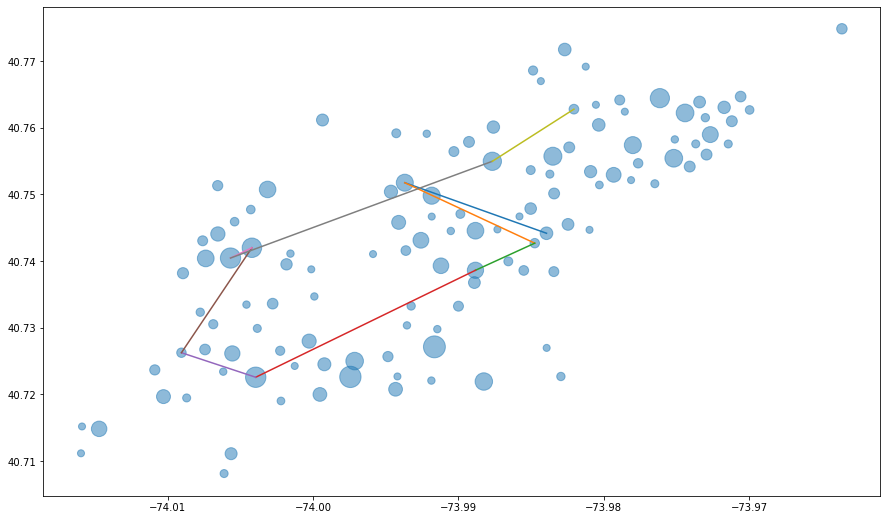

In [95]:
plot_genetetic_alg(alg)

## Test del rendimiento de los dos Algoritmos

En este apartado, voy a tratar de buscar una solución óptima al problema y generar una línea de 20 paradas y conectarlas de manera que la línea no sólo conecte las mejores estaciones, sino buscar que la línea sea lo más corta posible y que así los recorridos sean más cortos.

In [96]:
fg = first_gen(init=0, last=119, size=20, n_cromosomes=20, randseed=None, data=net_cl_df)

elit_alg = fg

for i in range(0, 1000):
    elit_alg = elitism_ga(elit_alg, 119)

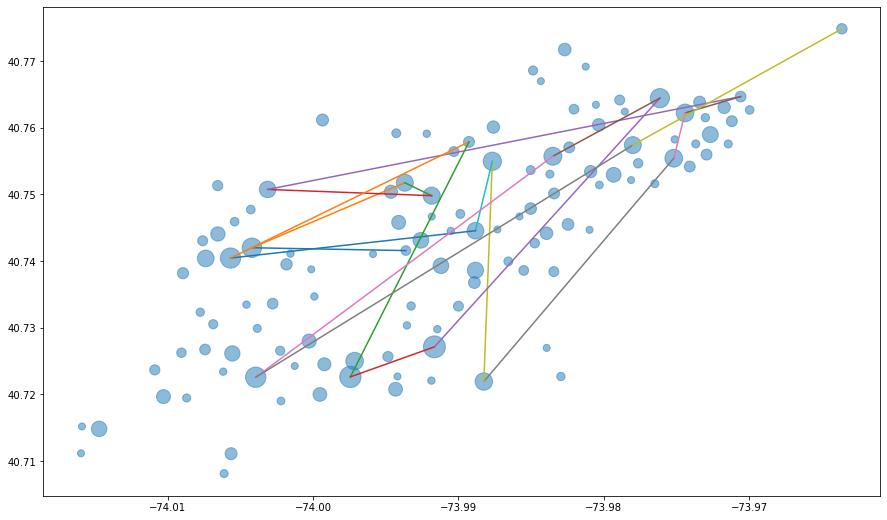

In [97]:
plot_genetetic_alg(elit_alg[0])

In [98]:
archive, alg = distance_genetic(generations=100)

In [99]:
archive.head(3)

population  distance
0  [6, 0, 1, 7, 4, 9, 3, 5, 2, 8]  8.829412
1  [6, 0, 1, 7, 4, 9, 3, 5, 2, 8]  8.829412
2  [6, 0, 1, 7, 4, 9, 3, 5, 2, 8]  8.829412

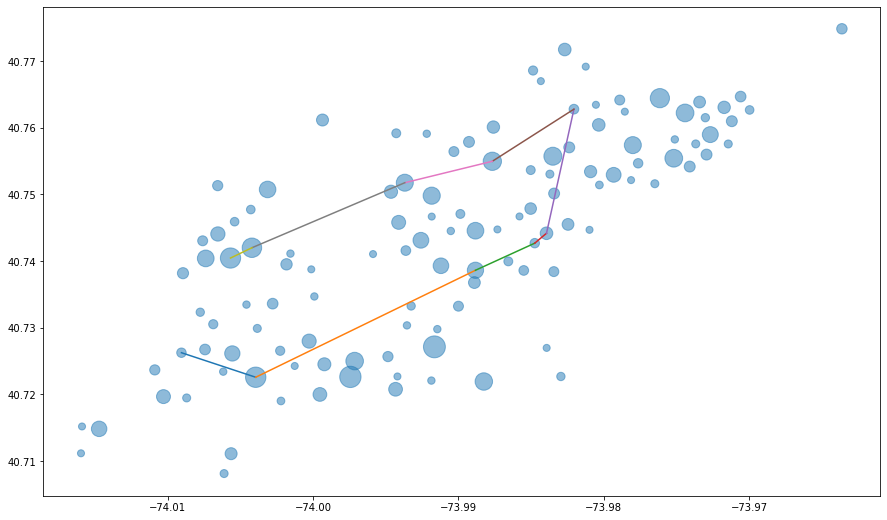

In [100]:
plot_genetetic_alg(alg)

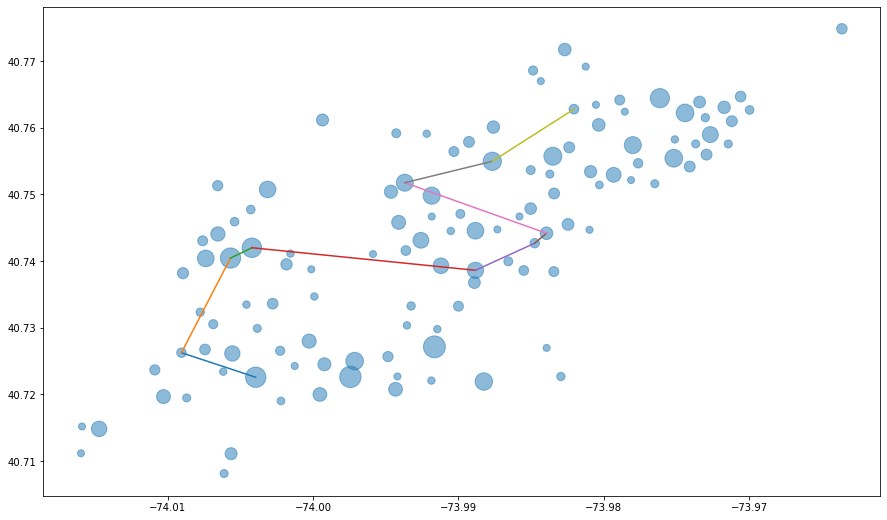

In [101]:
archive, alg = distance_genetic(generations=1000)

plot_genetetic_alg(alg)

In [102]:
archive.head(3)

population  distance
0  [0, 6, 8, 2, 1, 7, 4, 5, 3, 9]  7.292323
1  [0, 6, 8, 2, 1, 7, 4, 5, 3, 9]  7.292323
2  [0, 6, 8, 2, 1, 7, 4, 5, 3, 9]  7.292323

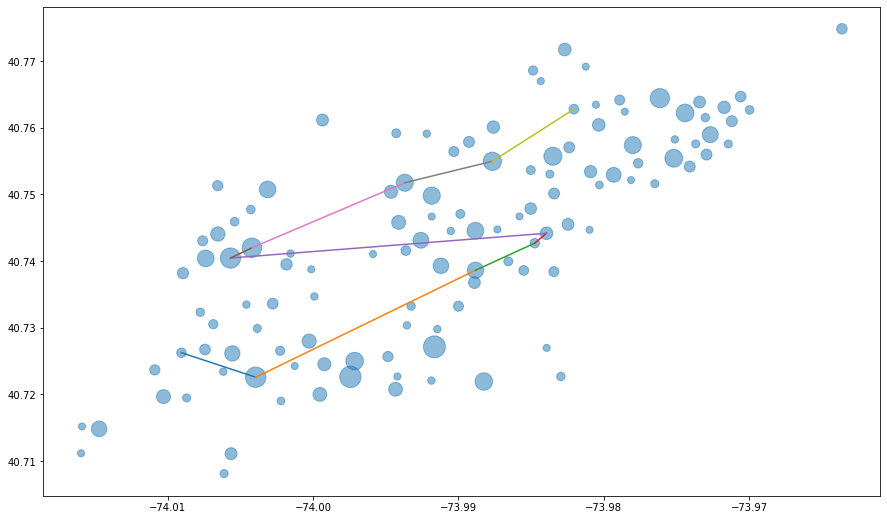

In [103]:
archive, alg = distance_genetic(generations=2500)

plot_genetetic_alg(alg)

Gracias al uso de los algoritmos genéticos, he conseguido formar una demo de una red de transporte obteniendo los enlaces entre las principales estaciones y reducir la distancia para que el recorrido no sea demasiado largo.

El actual es un ejempo de una aplicación práctica de los algoritmos genéticos para optimizar una red de transporte.

Este proyecto demuestra las capacidades prácticas que estos algoritmos tienen y algunas de las funciones que podrían llevar a cabo.